Originally from isolate_with_bedell.ipynb in the sculpting repo, I've adapted this former subsection of Lam & Ballard 2024 (submitted) into its own paper.

In [60]:
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.table import Table
import itertools
from itertools import combinations, zip_longest
import matplotlib.pyplot as plt
from scipy.stats import kstest, norm
import numpy.ma as ma # for masked arrays
%matplotlib inline
path = '/Users/chrislam/Desktop/mastrangelo/'
# all data downloaded from Berger et al 2020's ancillary tables: https://arxiv.org/src/2001.07737v3/anc
# the paper we're comparing against: https://arxiv.org/pdf/2005.14671.pdf


In [6]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

In [61]:
path = path+'period-ratios/'

In [62]:
df = pd.read_csv(path+'out/output.csv')
df

,timescale,end,formation,model,logL
0,0,0,0.0,[10.9 11.7 12.5 11.9],-13.156382
1,0,0,0.0,[10.2 12.6 12.8 11.4],-12.795148
2,0,0,0.0,[10.1 10.6 14.5 11.8],-11.321508
3,0,0,0.0,[10.5 13.3 12.8 10.4],-13.052693
4,0,0,0.0,[ 9.8 10.2 16.3 10.7],-10.252819
...,...,...,...,...,...
2415,19,10,1.0,[ 8.4 9.8 18.4 10.4],-9.156068
2416,19,10,1.0,[ 7.1 9.7 19.3 10.9],-8.737031
2417,19,10,1.0,[ 7.6 9.5 19.3 10.6],-8.795305
2418,19,10,1.0,[ 7.1 9.3 20.7 9.9],-8.537685


In [ ]:
def prior_transform(cube, gi_a, gi_b, gi_c):

	"""
	Each model run will use an evenly spaced tuple on a discrete 20 x 10 x 20 grid

    Inputs:
    - gi_a: log timescale at which dynamical sculpting of period ratios occurs
    - gi_b: possible end states of period ratios within the relevant period ratio window
    - gi_c: probability of a system following in-situ formation (random distribution) or migration

    Outputs:
    - cube of populated hyperparameters

	"""

	cube[0] = np.logspace(8, 10, 20)[gi_a]
	cube[1] = np.linspace(1.5, 1.6, 11)[gi_b]
	cube[2] = np.linspace(0, 1, 11)[gi_c]

	return cube

# convert parameters to sensible values
cube = prior_transform(

In [78]:
best_logL = np.max(df.logL)
min_logL = np.min(df.logL)
mean_logL = np.mean(df.logL)
median_logL = np.median(df.logL)
best_logL, min_logL, mean_logL, median_logL

(-8.402309701784578,
 -18.13388663900769,
 -10.469159016601532,
 -9.823444011001275)

Sarah: are there certain formation pathway likelihoods that are disfavored? We should expect so...but there are not.

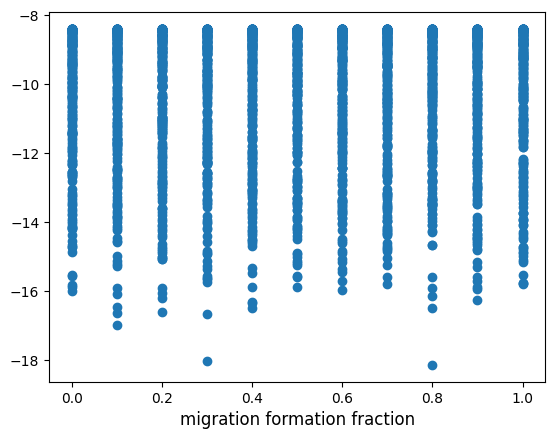

In [74]:
plt.scatter(df.formation, df.logL)
plt.xlabel('migration formation fraction')
plt.show()

Fine, let's table that. How about starting with what the different models produce? 

In [64]:
rows = []
for row in df["model"]:
    rows.append(np.array(row.strip("[ ]").split(), dtype=np.float32))
df['model'] = rows

yield_max = []
yield_min = []
for temp_list in zip_longest(*df.model):
    yield_max.append(np.max(temp_list))
    yield_min.append(np.min(temp_list))


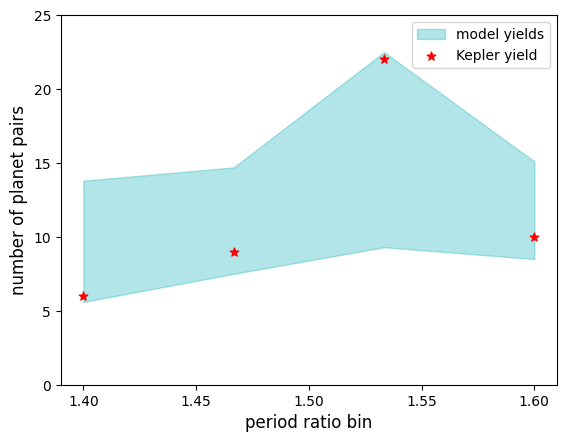

In [70]:
from ast import literal_eval

k = np.array([6., 9., 22., 10.])
x = np.linspace(1.4, 1.6, 4)
plt.fill_between(x, yield_max, yield_min, color='#03acb1', alpha=0.3, label='model yields')
plt.scatter(x, k, color='r', marker='*', s=40, label='Kepler yield')
plt.xlabel('period ratio bin')
plt.ylabel('number of planet pairs')
plt.legend()
plt.ylim([0, 25])
plt.locator_params(axis='x', nbins=8)

plt.show()

Cool. Clearly there are some models that do better than others. Maybe they are only apparent in 2D?

     timescale  end  formation  logL
0            0    0        0.0   1.0
1            0    1        0.0   1.0
2            0    2        0.0   1.0
3            0    3        0.0   1.0
4            0    4        0.0   1.0
..         ...  ...        ...   ...
215         19    6        1.0   1.0
216         19    7        1.0   1.0
217         19    8        1.0   1.0
218         19    9        1.0   1.0
219         19   10        1.0   1.0

[220 rows x 4 columns]


TypeError: DataFrame.pivot() takes 1 positional argument but 4 were given

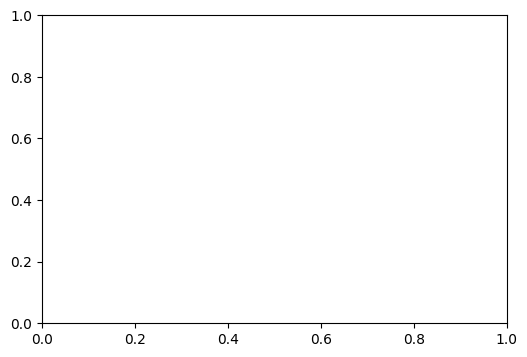

In [81]:
from matplotlib.colors import ListedColormap

f, ((ax1)) = plt.subplots(1, 1, figsize=(6, 4))

### 1
piv = df.groupby(['timescale','end']).max('logL').reset_index()
piv.loc[piv.logL >= median_logL,'logL'] = 1
piv.loc[piv.logL <  median_logL,'logL'] = 0
print(piv)
piv = piv.pivot("timescale","end","logL") # vs logged_normalized_likelihood
    
sns.heatmap(piv, yticklabels=recovery.end.unique().round(1), xticklabels=recovery.timescale.unique().round(1), ax=ax1, 
            cmap=ListedColormap(['steelblue','powderblue']), cbar=False)
ax1.set_yticks(ax1.get_yticks()[::2]) # sample every other tick, for cleanness
#ax1.set_title('m = -0.2, b = 1.0, c = 4e9, f = 0.3')
ax1.set(ylabel='intact fraction at 0.1 Gyr')
ax1.set(xlabel='sculpting slope [dex]')
#plt.savefig(path+'figures/2d_a.png', facecolor='white', bbox_inches='tight')
plt.show()

fasdfdaf


### 2
f, ((ax2)) = plt.subplots(1, 1, figsize=(6, 4))
piv = recovery.groupby(['ms','cs']).max('logLs').reset_index()
piv.loc[piv.logLs >= best_logL - delta_logL,'logLs'] = 1
piv.loc[piv.logLs <  best_logL - delta_logL,'logLs'] = 0
piv = piv.pivot("cs","ms","logLs") # vs logged_normalized_likelihood

sns.heatmap(piv, yticklabels=np.sort(np.round(recovery.cs.unique()/1e9,1)), xticklabels=recovery.ms.unique().round(1), 
            ax=ax2, cmap=ListedColormap(['steelblue','powderblue']), cbar=False)
ax2.set_yticks(ax2.get_yticks()[::2]) # sample every other tick, for cleanness
ax2.set(ylabel='cutoff timescale [Gyr]')
ax2.set(xlabel='sculpting slope [dex]')

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

white_patch = mpatches.Patch(color='powderblue', label='favored')
black_patch = mpatches.Patch(color='steelblue', label='not favored')
ax2.legend(handles=[white_patch, black_patch], loc='upper right')
#plt.legend(handles=[white_patch, black_patch])
#plt.savefig(path+'figures/2d_b.png', facecolor='white', bbox_inches='tight')
plt.show()

### 3
f, ((ax3)) = plt.subplots(1, 1, figsize=(6, 4))
piv = recovery.groupby(['cs','bs']).max('logLs').reset_index()
piv.loc[piv.logLs >= best_logL - delta_logL,'logLs'] = 1
piv.loc[piv.logLs <  best_logL - delta_logL,'logLs'] = 0
piv = piv.pivot("bs","cs","logLs") # vs logged_normalized_likelihood

sns.heatmap(piv, xticklabels=np.sort(np.round(recovery.cs.unique()/1e9,1)), yticklabels=recovery.bs.unique().round(1), 
            ax=ax3, cmap=ListedColormap(['steelblue','powderblue']), cbar=False)
ax3.set_yticks(ax3.get_yticks()[::2]) # sample every other tick, for cleanness
ax3.set(ylabel='intact fraction at 0.1 Gyr')
ax3.set(xlabel='cutoff timescale [Gyr]')
ax3.set_xticks(ax3.get_xticks()[::2]) # sample every other tick, for cleanness
#plt.savefig(path+'figures/2d_c.png', facecolor='white', bbox_inches='tight')
plt.show()

### 4
f, ((ax4)) = plt.subplots(1, 1, figsize=(6, 4))
piv = recovery.groupby(['fs','bs']).max('logLs').reset_index()
piv.loc[piv.logLs >= best_logL - delta_logL,'logLs'] = 1
piv.loc[piv.logLs <  best_logL - delta_logL,'logLs'] = 0
piv = piv.pivot("bs","fs","logLs") # vs logged_normalized_likelihood

sns.heatmap(piv, yticklabels=recovery.bs.unique().round(1), xticklabels=recovery.fs.unique().round(1), 
            ax=ax4, cmap=ListedColormap(['steelblue','powderblue']), cbar=False)
ax4.set_yticks(ax4.get_yticks()[::2]) # sample every other tick, for cleanness
ax4.set_xticks(ax4.get_xticks()[::2]) # sample every other tick, for cleanness
ax4.set(ylabel='intact fraction at 0.1 Gyr')
ax4.set(xlabel='planet host fraction')

#plt.savefig(path+'figures/2d_d.png', facecolor='white', bbox_inches='tight')
plt.show()

Compute k

In [13]:
print(kepler_planet_enriched.groupby('kepid').count().koi_count.reset_index().groupby('koi_count').count())

           kepid
koi_count       
1            833
2            134
3             38
4             15
5              5


Test: divide into "young" and "old" k's

In [15]:
young_all = kepler_stellar_enriched.loc[kepler_stellar_enriched.iso_age <= 2.]
old_all = kepler_stellar_enriched.loc[kepler_stellar_enriched.iso_age > 2.]

young = kepler_planet_enriched.loc[kepler_planet_enriched.iso_age <= 2.]
old = kepler_planet_enriched.loc[kepler_planet_enriched.iso_age > 2.]
print(young.groupby('kepid').count().koi_count.reset_index().groupby('koi_count').count())

print(old.groupby('kepid').count().koi_count.reset_index().groupby('koi_count').count())


           kepid
koi_count       
1             99
2             20
3              5
4              2
           kepid
koi_count       
1            734
2            114
3             33
4             13
5              5


### Period ratios

In [16]:
kepler_planet_enriched.koi_period

0       27.556452
1        9.931463
2        4.578344
3        7.407425
4       40.806533
          ...    
1295     6.830062
1296    49.490598
1297    37.793511
1298    24.668383
1299     1.847893
Name: koi_period, Length: 1300, dtype: float64

In [17]:
kepler_planet_enriched.iso_age

0       13.04
1        6.26
2        6.26
3        4.02
4        2.38
        ...  
1295     6.44
1296     1.78
1297     3.11
1298     2.26
1299     7.02
Name: iso_age, Length: 1300, dtype: float64

In [18]:
kepler_planet_enriched.kepid

0        1293379
1        1432789
2        1432789
3        1725016
4        1871056
          ...   
1295    12645057
1296    12690465
1297    12735793
1298    12737015
1299    12784167
Name: kepid, Length: 1300, dtype: int64

In [5]:
def quotient(a, b):
    return max(a,b)/min(a,b)

threshold = 4
### koi_score
young = kepler_planet_enriched.loc[kepler_planet_enriched.iso_age <= threshold]
old = kepler_planet_enriched.loc[kepler_planet_enriched.iso_age > threshold]

### fpp_prob
#young = kepler_planet_enriched_fpp.loc[kepler_planet_enriched_fpp.iso_age <= threshold]
#old = kepler_planet_enriched_fpp.loc[kepler_planet_enriched_fpp.iso_age > threshold]

old_ratios = []
young_ratios = []
all_ratios = []
for i in np.unique(old.kepid):
    system = old.loc[old.kepid == i]
    
    if len(system) > 1: # if multi
        
        pairs = itertools.combinations(system.koi_period, r=2)
        
        for pair in pairs:
            #print(quotient(*pair))
            old_ratios.append(quotient(*pair))
            
        #ratios = []
        """
        for sma in subset.koi_sma:
            all_ratios.append(ratio)
        """
        
for i in np.unique(young.kepid):
    system = young.loc[young.kepid == i]
    
    if len(system) > 1: # if multi
        
        pairs = itertools.combinations(system.koi_period, r=2)
        
        for pair in pairs:
            young_ratios.append(quotient(*pair))

for i in np.unique(kepler_planet_enriched.kepid):
    system = kepler_planet_enriched.loc[kepler_planet_enriched.kepid == i]
    
    if len(system) > 1: # if multi
        
        pairs = itertools.combinations(system.koi_period, r=2)
        
        for pair in pairs:
            all_ratios.append(quotient(*pair))
            
old_ratios = np.array(old_ratios)      
young_ratios = np.array(young_ratios)      
all_ratios = np.array(all_ratios)

print("K-S test result from comparing young and old: ", kstest(young_ratios, old_ratios))


K-S test result from comparing young and old:  KstestResult(statistic=0.06913165266106443, pvalue=0.7372817130685656)


old:  175
young:  117


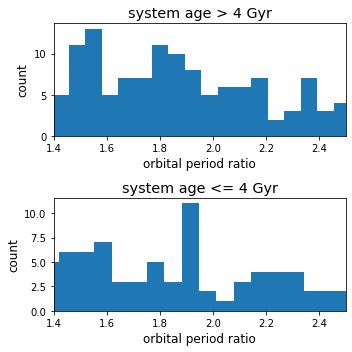

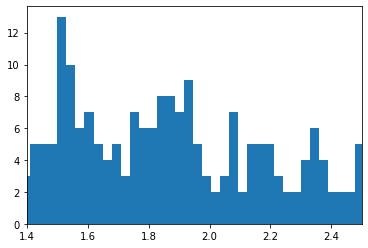

K-S test result from comparing young and old:  KstestResult(statistic=0.12727716727716729, pvalue=0.18343781123368175)


In [22]:
fig, axes = plt.subplots(figsize=(5,5))

cut = 4
bins = 45
ax1 = plt.subplot2grid((2,1), (0,0))
old_ratios = old_ratios[old_ratios < cut]
print("old: ", len(old_ratios))
ax1.hist(old_ratios, bins=bins)
ax1.set_title(f'system age > {threshold} Gyr')
ax1.set_xlabel('orbital period ratio')
ax1.set_ylabel('count')
ax1.set_xlim([0, cut])
ax1.set_xlim([1.4, 2.5])


ax2 = plt.subplot2grid((2,1), (1,0))
young_ratios = young_ratios[young_ratios < cut]
print("young: ", len(young_ratios))
ax2.hist(young_ratios, bins=bins)
ax2.set_title(f'system age <= {threshold} Gyr')
ax2.set_xlabel('orbital period ratio')
ax2.set_ylabel('count')
ax2.set_xlim([0, cut])
ax2.set_xlim([1.4, 2.5])


plt.tight_layout()
#plt.savefig(f'/Users/chrislam/Desktop/sculpting/paper/young-old-period-ratios-{threshold}gyr-fpp.png', format='png')
plt.show()

all_ratios = all_ratios[all_ratios < cut]
plt.hist(all_ratios, bins=100)
plt.xlim([1.4, 2.5])
plt.show()

print("K-S test result from comparing young and old: ", kstest(young_ratios, old_ratios))

In [23]:
print(len(old_ratios[(old_ratios > 1.9) & (old_ratios < 1.95)]))
print(len(old_ratios[(old_ratios > 1.95) & (old_ratios < 2.)]))
print(len(old_ratios[(old_ratios > 2) & (old_ratios < 2.05)]))
print(len(old_ratios[(old_ratios > 2.05) & (old_ratios < 2.1)]))
print(len(old_ratios[(old_ratios > 2.1) & (old_ratios < 2.15)]))
print(len(old_ratios[(old_ratios > 2.15) & (old_ratios < 2.2)]))
print("")

print(len(old_ratios[(old_ratios > 1.4) & (old_ratios < 1.5)]))
print(len(old_ratios[(old_ratios > 1.5) & (old_ratios < 1.6)]))

6
4
6
4
7
5

9
20


In [24]:
print(len(young_ratios[(young_ratios > 1.95) & (young_ratios < 2)]))
print(len(young_ratios[(young_ratios > 2) & (young_ratios < 2.05)]))
print(len(young_ratios[(young_ratios > 2.05) & (young_ratios < 2.1)]))
print("")

print(len(young_ratios[(young_ratios > 1.4) & (young_ratios < 1.5)]))
print(len(young_ratios[(young_ratios > 1.5) & (young_ratios < 1.6)]))

1
1
3

6
12


In [25]:
print(len(all_ratios[(all_ratios > 1.9) & (all_ratios < 2)]))
print(len(all_ratios[(all_ratios > 2) & (all_ratios < 2.1)]))
print(len(all_ratios[(all_ratios > 2.1) & (all_ratios < 2.2)]))
print(len(all_ratios[(all_ratios > 2.2) & (all_ratios < 2.3)]))
print("")

print(len(all_ratios[(all_ratios > 1.95) & (all_ratios < 2)]))
print(len(all_ratios[(all_ratios > 2) & (all_ratios < 2.05)]))
print("")

print(len(all_ratios[(all_ratios > 1.4) & (all_ratios < 1.5)]))
print(len(all_ratios[(all_ratios > 1.5) & (all_ratios < 1.6)]))
print("")

print(len(all_ratios[(all_ratios > 1.45) & (all_ratios < 1.5)]))
print(len(all_ratios[(all_ratios > 1.5) & (all_ratios < 1.55)]))

21
14
14
10

5
7

15
32

9
22


#### Comparing samples of different sizes can be fraught. Here's a K-S test to make it...less fraught

In [6]:
from scipy.stats import kstest, norm

kstest(young_ratios, old_ratios)

rng = np.random.default_rng()
test_norm_distribution = norm.rvs(size=100, loc=0.5, random_state=rng)
kstest(test_norm_distribution, old_ratios)

KstestResult(statistic=0.81, pvalue=0.0)

A KS-test result of under 0.05 suggests that these are likely drawn from two different populations.

Before we start the next experiment, let's make explicit the machinery used to re-sample stellar ages. 

How are there no multi-planet systems in K2??

In [7]:
def binomial_pmf(f, array, ratio): 
    
    """
    Compute bionmial distribution probability mass function (PMF). 
    If I toss a coin and get some observed distribution of planet period ratios < and > than some integer ratio, 
    what's the probability that the true bias of the coin is f? 
    That is, if the coin is fair (if planet pairs are evenly distributed around integer ratios), 
    then I'd expect the peak of the likelihood function to be at f=0.5.
    
    Inputs:
    - f: coin bias test fraction
    - array: array of observed ratios [np.array]
    - ratio: the planet-period ratio in question
    
    Returns:
    - PMF: probability mass function
    
    """
    
    less_than = array[(array >= ratio - 0.1) & (array <= ratio)]
    greater_than = array[(array <= ratio + 0.1) & (array >= ratio)]
    #print(f"<{ratio}:", f"{len(less_than)}")
    #print(f">{ratio}:", f"{len(greater_than)}")
    likelihood = f**(len(less_than)) * (1-f)**(len(greater_than))
                   
    return likelihood

def binomial_null(f, n):
    
    """
    Construct fair-coin-toss binomial distribution.
    
    Inputs:
    - f: 0.5 for a fair coin
    - n: number of flips (should be equal to the sample size being compared)
    """
    
    n = n/2 # half for heads; half for tails
    likelihood = (f**n) * ((1-f)**n)
    
    return likelihood

def quotient(a, b):
    return max(a,b)/min(a,b)

In [8]:
def period_ratios(df, threshold):
    
    """
    Calculate period ratio distributions for young and old samples at different thresholds
    
    Input: 
    - df: kepler_planet_enriched DataFrame, with re-assigned age from bootstrapping
    - young-old threshold [Gyrs; int]
    
    Returns: old, young, and all ratios [np.arrays]
    
    """
    
    ### koi_score
    young = df.loc[df.age <= threshold]
    old = df.loc[df.age > threshold]

    ### fpp_prob
    #young = kepler_planet_enriched_fpp.loc[kepler_planet_enriched_fpp.iso_age <= threshold]
    #old = kepler_planet_enriched_fpp.loc[kepler_planet_enriched_fpp.iso_age > threshold]

    old_ratios = []
    young_ratios = []
    all_ratios = []
    for i in np.unique(old.kepid):
        system = old.loc[old.kepid == i]

        if len(system) > 1: # if multi

            pairs = itertools.combinations(system.koi_period, r=2)

            for pair in pairs:
                #print(quotient(*pair))
                old_ratios.append(quotient(*pair))
                
            #ratios = []
            """
            for sma in subset.koi_sma:
                all_ratios.append(ratio)
            """

    for i in np.unique(young.kepid):
        system = young.loc[young.kepid == i]

        if len(system) > 1: # if multi

            pairs = itertools.combinations(system.koi_period, r=2)

            for pair in pairs:
                young_ratios.append(quotient(*pair))

    #for i in np.unique(kepler_planet_enriched_fpp.kepid):
    #    system = kepler_planet_enriched_fpp.loc[kepler_planet_enriched_fpp.kepid == i]
    for i in np.unique(df.kepid):
        system = df.loc[df.kepid == i]
        
        if len(system) > 1: # if multi

            pairs = itertools.combinations(system.koi_period, r=2)

            for pair in pairs:
                all_ratios.append(quotient(*pair))

    old_ratios = np.array(old_ratios)      
    young_ratios = np.array(young_ratios)      
    all_ratios = np.array(all_ratios)
    
    return old_ratios, young_ratios, all_ratios

In [9]:
def plot(ax, threshold, ratio):
    
    # first run, for plotting and norm_factor
    kepler_planet_enriched['age'] =  random.normal(kepler_planet_enriched.iso_age, kepler_planet_enriched.iso_age_err)
    old_ratios, young_ratios, all_ratios = period_ratios(kepler_planet_enriched, threshold)
    young_likelihood = binomial_pmf(fs, young_ratios, ratio)
    
    # normalize everything to the same value
    norm_factor = max(young_likelihood)
    old_likelihood = norm_factor*binomial_pmf(fs, old_ratios, ratio)/max(binomial_pmf(fs, old_ratios, ratio))
    ax.plot(fs, young_likelihood, alpha=0.2, color='#89bedc', label=f'<{threshold} Gyr')
    ax.plot(fs, old_likelihood, alpha=0.2, color='#fdc692', label=f'>{threshold} Gyr')
    
    # null hypothesis
    sample_size = min(len(old_ratios),len(young_ratios))
    normalized_binomial_null = norm_factor*binomial_null(fs, sample_size)/max(binomial_null(fs, sample_size))
    ax.plot(fs, normalized_binomial_null, label='null hypothesis', color='k')

    ax.set_xlabel(f'fraction of planet-pairs with period ratio < {ratio}')
    ax.set_ylabel('likelihood')

    for i in range(10):

        kepler_planet_enriched['age'] =  random.normal(kepler_planet_enriched.iso_age, kepler_planet_enriched.iso_age_err)

        # collect period ratios for each young/old sample
        old_ratios, young_ratios, all_ratios = period_ratios(kepler_planet_enriched, threshold)

        # calculate binomial PDFs for each young/old sample
        young_likelihood = norm_factor*binomial_pmf(fs, young_ratios, ratio)/max(binomial_pmf(fs, young_ratios, ratio))
        old_likelihood = norm_factor*binomial_pmf(fs, old_ratios, ratio)/max(binomial_pmf(fs, old_ratios, ratio))

        ax.plot(fs, young_likelihood, alpha=0.4, color='#89bedc')
        ax.plot(fs, old_likelihood, alpha=0.4, color='#fdc692')
    
    ax.legend(loc='upper right')
    
    return old_ratios, young_ratios, all_ratios

In [ ]:
_, _, all_ratios = period_ratios(kepler_planet_enriched, 8)

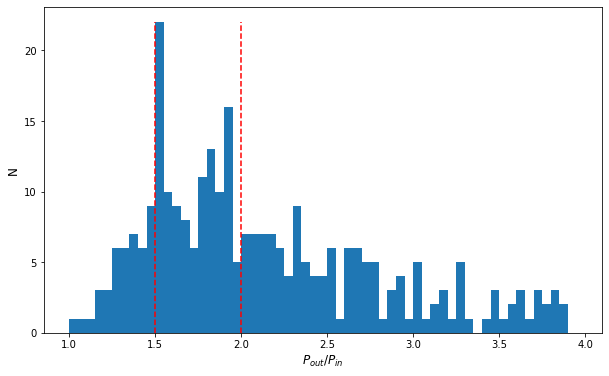

In [11]:
plt.figure(figsize=(10, 6))
bins = np.arange(1, 4, 0.05)
y, x, _ = plt.hist(all_ratios, bins=bins)
plt.vlines(1.5, 0, max(y), linestyle='--', color='r')
plt.vlines(2., 0, max(y), linestyle='--', color='r')
plt.xlabel(r'$P_{out}$/$P_{in}$')
plt.ylabel('N')
plt.show()

In [17]:
np.sum(y)

290.0

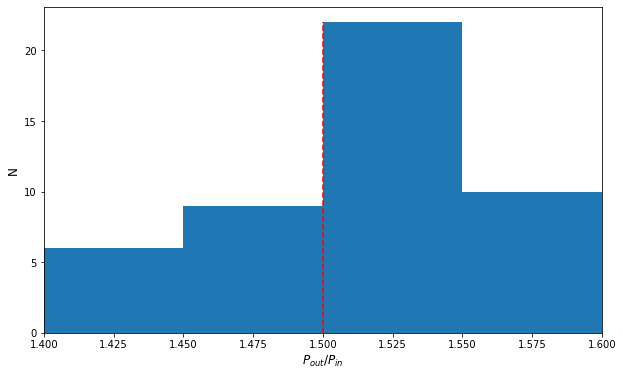

[ 6.  9. 22. 10.]


In [22]:
plt.figure(figsize=(10, 6))
bins = np.arange(1.4, 1.6, 0.05)
y, x, _ = plt.hist(all_ratios, bins=bins)
plt.vlines(1.5, 0, max(y), linestyle='--', color='r')
plt.vlines(2., 0, max(y), linestyle='--', color='r')
plt.xlabel(r'$P_{out}$/$P_{in}$')
plt.ylabel('N')
plt.xlim([1.4, 1.6])
plt.show()

print(y)

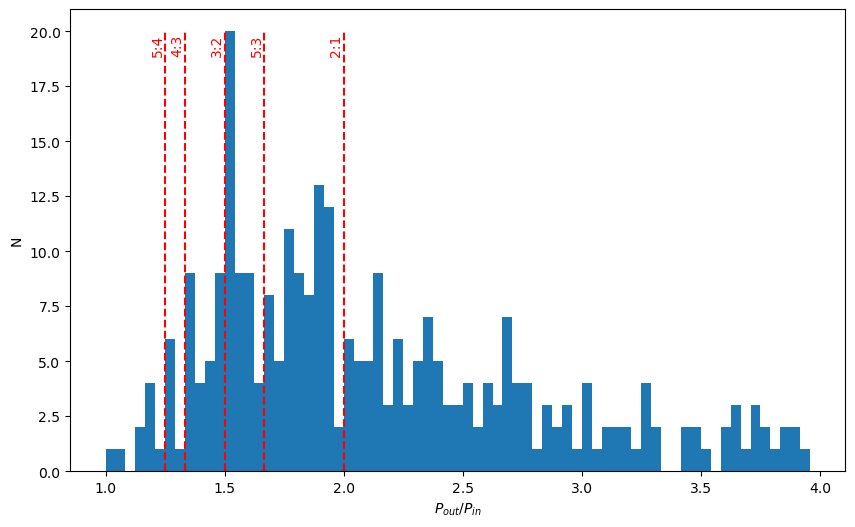

In [257]:
plt.figure(figsize=(10, 6))
bins = np.arange(1, 4, 1/24)
y, x, _ = plt.hist(all_ratios, bins=bins)
plt.vlines(1.5, 0, max(y), linestyle='--', color='r')
plt.vlines(2., 0, max(y), linestyle='--', color='r')
plt.vlines(5./4, 0, max(y), linestyle='--', color='r')
plt.vlines(4./3, 0, max(y), linestyle='--', color='r')
plt.vlines(5./3, 0, max(y), linestyle='--', color='r')

plt.text(1.5-0.06,max(y)-1,'3:2',rotation=90,color='r')
plt.text(2.-0.06,max(y)-1,'2:1',rotation=90,color='r')
plt.text(5/4-0.06,max(y)-1,'5:4',rotation=90,color='r')
plt.text(4/3-0.06,max(y)-1,'4:3',rotation=90,color='r')
plt.text(5/3-0.06,max(y)-1,'5:3',rotation=90,color='r')

plt.xlabel(r'$P_{out}$/$P_{in}$')
plt.ylabel('N')
plt.savefig(path+'figures/ratios.png')
plt.show()

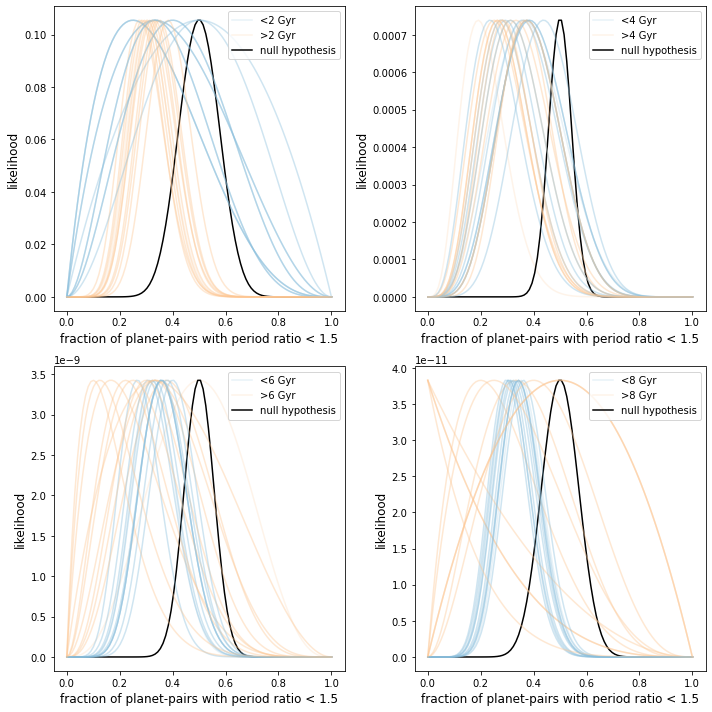

In [180]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

random = np.random.default_rng(seed=42)
#thresholds = np.linspace(2,9,8) # vary threshold from 2 to 9 Gyrs
#thresholds = np.array([2,4,8])
#threshold = 2
ratio = 1.5
fs = np.linspace(0, 1, 100)
kepler_planet_enriched['iso_age_err'] = 0.5 * (kepler_planet_enriched.iso_age_err1 + np.abs(kepler_planet_enriched.iso_age_err2))

threshold = 2
plot(ax1, threshold, ratio)

threshold = 4
plot(ax2, threshold, ratio)

threshold = 6
plot(ax3, threshold, ratio)

threshold = 8
plot(ax4, threshold, ratio)

plt.tight_layout()
#plt.savefig(path+'figures/period_ratios_3_2_narrow.png')
plt.show()


2:1 period ratio

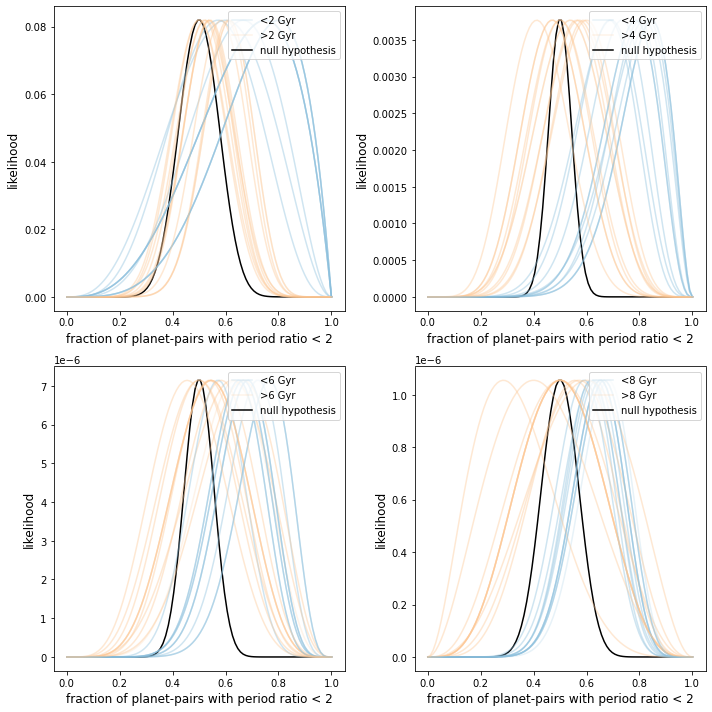

In [181]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

random = np.random.default_rng(seed=42)
#thresholds = np.linspace(2,9,8) # vary threshold from 2 to 9 Gyrs
#thresholds = np.array([2,4,8])
#threshold = 2
ratio = 2
fs = np.linspace(0, 1, 100)
kepler_planet_enriched['iso_age_err'] = 0.5 * (kepler_planet_enriched.iso_age_err1 + np.abs(kepler_planet_enriched.iso_age_err2))

threshold = 2
plot(ax1, threshold, ratio)

threshold = 4
plot(ax2, threshold, ratio)

threshold = 6
plot(ax3, threshold, ratio)

threshold = 8
plot(ax4, threshold, ratio)

plt.tight_layout()
#plt.savefig(path+'figures/period_ratios_2_1_narrow.png')
plt.show()


### K2

In [22]:
k2 = pd.read_csv(path+'/data/k2pandc_2023.10.23_12.20.42.csv')
k2

,pl_name,hostname,default_flag,disposition,disp_refname,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,...,sy_vmagerr2,sy_kmag,sy_kmagerr1,sy_kmagerr2,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2,rowupdate,pl_pubdate,releasedate
0,K2-33 b,K2-33,0,CONFIRMED,David et al. 2016,1,1,Transit,2016,K2,...,-0.126,10.026,0.019,-0.019,14.15700,0.000900,-0.000900,2016-07-06,2016-06,2016-06-23
1,K2-33 b,K2-33,1,CONFIRMED,David et al. 2016,1,1,Transit,2016,K2,...,-0.126,10.026,0.019,-0.019,14.15700,0.000900,-0.000900,2016-07-06,2016-09,2016-06-23
2,V1298 Tau b,V1298 Tau,0,CONFIRMED,David et al. 2019,3,4,Transit,2019,K2,...,-0.009,8.094,0.021,-0.021,10.07020,0.000682,-0.000682,2023-04-10,2021-12,2023-04-10
3,V1298 Tau c,V1298 Tau,0,CONFIRMED,David et al. 2019,3,4,Transit,2019,K2,...,-0.009,8.094,0.021,-0.021,10.07020,0.000682,-0.000682,2023-04-10,2021-12,2023-04-10
4,V1298 Tau d,V1298 Tau,0,CONFIRMED,David et al. 2019,3,4,Transit,2019,K2,...,-0.009,8.094,0.021,-0.021,10.07020,0.000682,-0.000682,2023-04-10,2021-12,2023-04-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,Wolf 503 b,Wolf 503,0,CONFIRMED,Peterson et al. 2018,1,1,Transit,2018,K2,...,-0.030,7.617,0.023,-0.023,9.89816,0.000337,-0.000337,2022-05-23,2021-12,2022-05-23
232,K2-111 b,K2-111,0,CONFIRMED,Fridlund et al. 2017,1,2,Transit,2017,K2,...,-0.034,9.377,0.021,-0.021,10.92940,0.000621,-0.000621,2020-12-10,2020-10,2020-12-17
233,K2-111 c,K2-111,0,CONFIRMED,Mortier et al. 2020,1,2,Radial Velocity,2020,Multiple Observatories,...,-0.034,9.377,0.021,-0.021,10.92940,0.000621,-0.000621,2020-12-10,2020-10,2020-12-17
234,K2-111 b,K2-111,1,CONFIRMED,Fridlund et al. 2017,1,2,Transit,2017,K2,...,-0.034,9.377,0.021,-0.021,10.92940,0.000621,-0.000621,2023-04-17,2023-04,2023-04-17


147


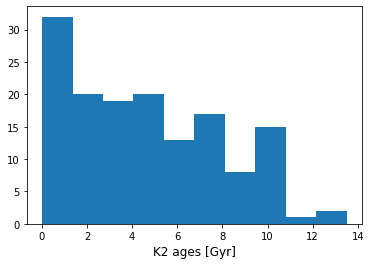

In [39]:
print(len(k2.st_age.dropna()))
plt.hist(k2.st_age)
plt.xlabel('K2 ages [Gyr]')
plt.show()

In [24]:
# drop rows without stellar age, and compute mean stellar age error, given asymmetric age errors
k2 = k2.dropna(subset=['st_age'])
k2['ageerr'] = 0.5 * (k2['st_ageerr1'] + np.abs(k2['st_ageerr2']))

In [25]:
k2

,pl_name,hostname,default_flag,disposition,disp_refname,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,...,sy_kmag,sy_kmagerr1,sy_kmagerr2,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2,rowupdate,pl_pubdate,releasedate,ageerr
0,K2-33 b,K2-33,0,CONFIRMED,David et al. 2016,1,1,Transit,2016,K2,...,10.026,0.019,-0.019,14.15700,0.000900,-0.000900,2016-07-06,2016-06,2016-06-23,0.003
1,K2-33 b,K2-33,1,CONFIRMED,David et al. 2016,1,1,Transit,2016,K2,...,10.026,0.019,-0.019,14.15700,0.000900,-0.000900,2016-07-06,2016-09,2016-06-23,0.001
2,V1298 Tau b,V1298 Tau,0,CONFIRMED,David et al. 2019,3,4,Transit,2019,K2,...,8.094,0.021,-0.021,10.07020,0.000682,-0.000682,2023-04-10,2021-12,2023-04-10,0.010
3,V1298 Tau c,V1298 Tau,0,CONFIRMED,David et al. 2019,3,4,Transit,2019,K2,...,8.094,0.021,-0.021,10.07020,0.000682,-0.000682,2023-04-10,2021-12,2023-04-10,0.010
4,V1298 Tau d,V1298 Tau,0,CONFIRMED,David et al. 2019,3,4,Transit,2019,K2,...,8.094,0.021,-0.021,10.07020,0.000682,-0.000682,2023-04-10,2021-12,2023-04-10,0.010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,Wolf 503 b,Wolf 503,0,CONFIRMED,Peterson et al. 2018,1,1,Transit,2018,K2,...,7.617,0.023,-0.023,9.89816,0.000337,-0.000337,2022-05-23,2021-12,2022-05-23,2.000
232,K2-111 b,K2-111,0,CONFIRMED,Fridlund et al. 2017,1,2,Transit,2017,K2,...,9.377,0.021,-0.021,10.92940,0.000621,-0.000621,2020-12-10,2020-10,2020-12-17,0.700
233,K2-111 c,K2-111,0,CONFIRMED,Mortier et al. 2020,1,2,Radial Velocity,2020,Multiple Observatories,...,9.377,0.021,-0.021,10.92940,0.000621,-0.000621,2020-12-10,2020-10,2020-12-17,0.700
234,K2-111 b,K2-111,1,CONFIRMED,Fridlund et al. 2017,1,2,Transit,2017,K2,...,9.377,0.021,-0.021,10.92940,0.000621,-0.000621,2023-04-17,2023-04,2023-04-17,0.650


In [27]:
# drop duplicates, keeping duplicate with the smallest mean stellar age error
k2 = k2.sort_values('ageerr', ascending=True).drop_duplicates('pl_name').sort_index()

In [28]:
# what's the transit multiplicity?
k2.groupby('hostname').count().st_age.reset_index().groupby('st_age').count().reset_index()

,st_age,hostname
0,1,75
1,2,18
2,3,6
3,4,3
4,6,1


In [29]:
# rename system name and orbital period, to comply with period_ratios()
k2['kepid'] = k2['hostname']
k2['koi_period'] = k2['pl_orbper']

In [182]:
def plot_k2(ax, threshold, ratio):
    
    # first run, for plotting and norm_factor
    k2['age'] =  random.normal(k2.st_age, k2.ageerr)
    old_ratios, young_ratios, all_ratios = period_ratios(k2, threshold)
    young_likelihood = binomial_pmf(fs, young_ratios, ratio)
    # normalize everything to the same value
    norm_factor = max(young_likelihood)
    old_likelihood = norm_factor*binomial_pmf(fs, old_ratios, ratio)/max(binomial_pmf(fs, old_ratios, ratio))
    ax.plot(fs, young_likelihood, alpha=0.2, color='#89bedc', label=f'<{threshold} Gyr')
    ax.plot(fs, old_likelihood, alpha=0.2, color='#fdc692', label=f'>{threshold} Gyr')

    # null hypothesis
    sample_size = min(len(old_ratios),len(young_ratios))
    normalized_binomial_null = norm_factor*binomial_null(fs, sample_size)/max(binomial_null(fs, sample_size))
    ax.plot(fs, normalized_binomial_null, label='null hypothesis', color='k')

    ax.set_xlabel(f'fraction of planet-pairs with period ratio < {ratio}')
    ax.set_ylabel('likelihood')

    for i in range(10):

        k2['age'] =  random.normal(k2.st_age, k2.ageerr)

        # collect period ratios for each young/old sample
        old_ratios, young_ratios, all_ratios = period_ratios(k2, threshold)
        
        # calculate binomial PDFs for each young/old sample
        young_likelihood = norm_factor*binomial_pmf(fs, young_ratios, ratio)/max(binomial_pmf(fs, young_ratios, ratio))
        old_likelihood = norm_factor*binomial_pmf(fs, old_ratios, ratio)/max(binomial_pmf(fs, old_ratios, ratio))

        ax.plot(fs, young_likelihood, alpha=0.4, color='#89bedc')
        ax.plot(fs, old_likelihood, alpha=0.4, color='#fdc692')
    
    ax.legend(loc='upper right')
    
    return

<1.5: 1
>1.5: 4
<1.5: 0
>1.5: 2
<1.5: 0
>1.5: 2
<1.5: 1
>1.5: 1
<1.5: 1
>1.5: 1
<1.5: 0
>1.5: 6
<1.5: 0
>1.5: 6
<1.5: 1
>1.5: 2
<1.5: 1
>1.5: 2
<1.5: 0
>1.5: 2
<1.5: 0
>1.5: 2
<1.5: 1
>1.5: 2
<1.5: 1
>1.5: 2
<1.5: 0
>1.5: 2
<1.5: 0
>1.5: 2
<1.5: 1
>1.5: 1
<1.5: 1
>1.5: 1
<1.5: 0
>1.5: 4
<1.5: 0
>1.5: 4
<1.5: 1
>1.5: 2
<1.5: 1
>1.5: 2
<1.5: 0
>1.5: 2
<1.5: 0
>1.5: 2
<1.5: 1
>1.5: 1
<1.5: 1
>1.5: 1
<1.5: 0
>1.5: 3
<1.5: 0
>1.5: 3
<1.5: 1
>1.5: 1
<1.5: 1
>1.5: 1
<1.5: 0
>1.5: 5
<1.5: 0
>1.5: 5
<1.5: 1
>1.5: 3
<1.5: 1
>1.5: 3
<1.5: 0
>1.5: 2
<1.5: 0
>1.5: 2
<1.5: 1
>1.5: 1
<1.5: 1
>1.5: 1
<1.5: 0
>1.5: 6
<1.5: 0
>1.5: 6
<1.5: 1
>1.5: 1
<1.5: 1
>1.5: 1
<1.5: 0
>1.5: 2
<1.5: 0
>1.5: 2
<1.5: 1
>1.5: 4
<1.5: 0
>1.5: 0
<1.5: 0
>1.5: 0
<1.5: 1
>1.5: 3
<1.5: 1
>1.5: 3
<1.5: 0
>1.5: 3
<1.5: 0
>1.5: 3
<1.5: 1
>1.5: 3
<1.5: 1
>1.5: 3
<1.5: 0
>1.5: 1
<1.5: 0
>1.5: 1
<1.5: 1
>1.5: 1
<1.5: 1
>1.5: 1
<1.5: 0
>1.5: 3
<1.5: 0
>1.5: 3
<1.5: 1
>1.5: 2
<1.5: 1
>1.5: 2
<1.5: 0
>1.5: 3
<1.5: 0
>1.5: 3
<1.5: 1


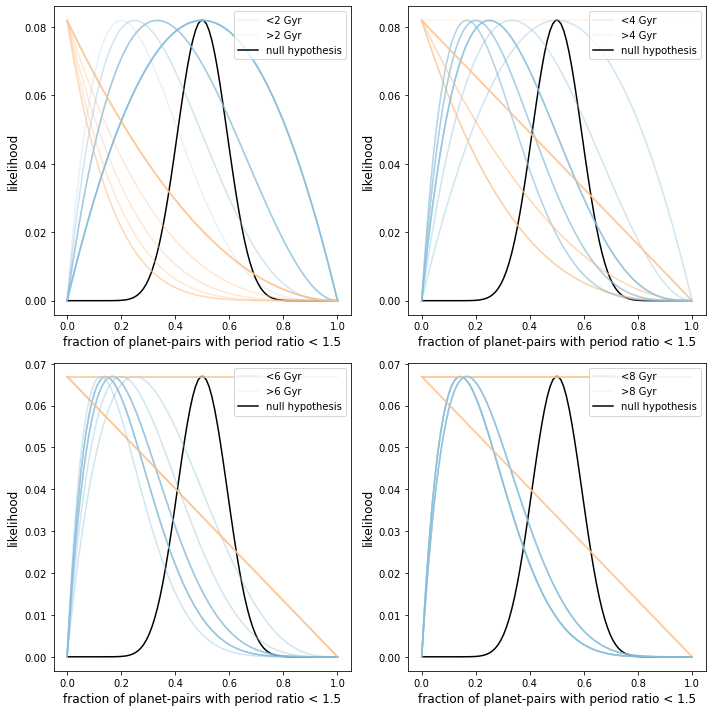

In [41]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

random = np.random.default_rng(seed=42)
ratio = 1.5
fs = np.linspace(0, 1, 100)

threshold = 2
plot_k2(ax1, threshold, ratio)

threshold = 4
plot_k2(ax2, threshold, ratio)

threshold = 6
plot_k2(ax3, threshold, ratio)

threshold = 8
plot_k2(ax4, threshold, ratio)

plt.tight_layout()
plt.savefig(path+'figures/k2_period_ratios_3_2.png')
plt.show()


(array([ 3., 25., 23., 21., 13., 10., 13., 10.,  7.,  9.]),
 array([-2.07876592, -0.4385926 ,  1.20158072,  2.84175404,  4.48192737,
         6.12210069,  7.76227401,  9.40244733, 11.04262065, 12.68279397,
        14.32296729]),
 <BarContainer object of 10 artists>)

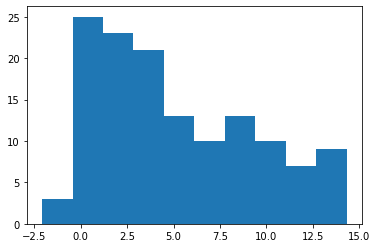

In [38]:
plt.hist(k2.age)

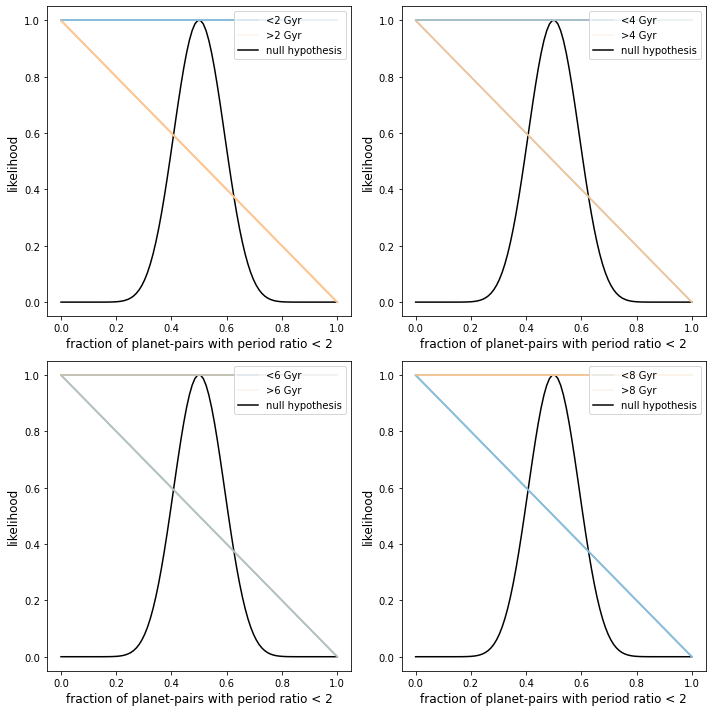

In [36]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

random = np.random.default_rng(seed=42)
ratio = 2
fs = np.linspace(0, 1, 100)

threshold = 2
plot_k2(ax1, threshold, ratio)

threshold = 4
plot_k2(ax2, threshold, ratio)

threshold = 6
plot_k2(ax3, threshold, ratio)

threshold = 8
plot_k2(ax4, threshold, ratio)

plt.tight_layout()
plt.savefig(path+'figures/k2_period_ratios_2_1.png')
plt.show()


### TESS period ratios

We use TESS-Kepler-Gaia crossmatch from Berger+ 2023, Table 4: https://arxiv.org/pdf/2301.11338.pdf

In [51]:
tess = pd.read_csv(path+'data/PS_2023.10.24_10.08.08.csv')
tess = pd.read_csv(path+'data/GKTHCatalog_Table4.csv')

In [64]:
tess = tess.loc[tess['iso_age'].str.contains('\*') == False] # remove uninformative ages, tagged with *
tess

,id_starname,iso_teff,iso_teff_err1,iso_teff_err2,iso_logg,iso_logg_err1,iso_logg_err2,iso_feh,iso_feh_err1,iso_feh_err2,...,iso_lum,iso_lum_err1,iso_lum_err2,iso_age,iso_age_err1,iso_age_err2,iso_dis,iso_dis_err1,iso_dis_err2,iso_avs
0,kic10797460,5610.428845,117.294338,-124.168986,4.497660,0.033374,-0.056760,-0.034105,0.133539,-0.131970,...,0.729697,0.056428,-0.043791,3.651,5.392,-2.824,1062.856851,21.538854,-24.160344,0.256322
1,kic10811496,5832.172919,142.563861,-167.971579,4.352472,0.062371,-0.076938,0.102351,0.139104,-0.140201,...,1.314130,0.107212,-0.098462,4.867,4.321,-3.305,1505.901487,56.173540,-54.329951,0.192158
2,kic10854555,5660.415369,121.044195,-136.058983,4.475518,0.042595,-0.068506,-0.079961,0.133657,-0.132232,...,0.793808,0.053709,-0.049752,4.612,6.024,-3.488,1228.031853,37.415832,-36.677005,0.164707
3,kic10872983,5837.403566,127.043768,-144.201185,4.423377,0.041232,-0.064742,0.046694,0.142958,-0.134580,...,1.119828,0.104213,-0.097471,3.182,4.149,-2.400,1518.798397,62.815684,-54.662658,0.328002
5,kic11446443,5818.603913,125.254952,-141.451984,4.430884,0.046334,-0.068416,-0.079644,0.131897,-0.135200,...,1.028887,0.038749,-0.035631,4.375,5.059,-3.184,213.776310,3.034876,-2.980035,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7988,tic320536216,7943.750417,172.893647,-153.098973,4.251967,0.034316,-0.040759,-0.031419,0.155069,-0.201378,...,9.081913,0.442951,-0.393495,0.511,0.392,-0.324,398.251560,6.526536,-6.273119,0.000000
7989,tic207277638,8006.163534,187.824742,-180.490382,4.211495,0.048453,-0.049554,-0.137903,0.165227,-0.207981,...,10.023585,0.792867,-0.733343,0.78,0.378,-0.375,389.785929,13.740692,-12.973113,0.109805
7990,tic88684250,8411.401871,198.373373,-173.006745,4.138061,0.037050,-0.039849,0.066914,0.165822,-0.200607,...,17.120154,0.916376,-0.840055,0.572,0.235,-0.188,497.759310,8.356919,-8.254485,0.054902
7991,tic7561203,9599.285077,423.235083,-368.259614,4.113539,0.048675,-0.045812,-0.226734,0.199972,-0.207469,...,34.034770,5.112669,-5.146729,0.519,0.164,-0.162,606.867908,20.460008,-15.409759,0.093152


In [66]:
tess_planets = pd.read_csv(path+'data/GKTHCatalog_Table5.csv')

In [70]:
tess = tess.merge(tess_planets, on='id_starname').dropna()

In [73]:
tess[['iso_age','orbper']]

,iso_age,orbper
0,3.651,9.488036
1,3.651,54.418383
2,4.867,19.899140
3,4.612,2.525592
4,3.182,11.094321
...,...,...
7407,0.511,0.547669
7408,0.78,3.121540
7409,0.572,4.587373
7410,0.519,2.484030


In [75]:
# create symmetric age error from asymmetric age errors
tess['ageerr'] = 0.5 * (tess['iso_age_err1'] + np.abs(tess['iso_age_err2']))

In [76]:
# what's the transit multiplicity?
tess.groupby('id_starname').count().iso_age.reset_index().groupby('iso_age').count().reset_index()

,iso_age,id_starname
0,1,4995
1,2,471
2,3,144
3,4,48
4,5,12
5,6,3
6,7,1


In [77]:
# rename system name and orbital period, to comply with period_ratios()
tess['kepid'] = tess['id_starname']
tess['koi_period'] = tess['orbper']

In [235]:
def plot_df(df, ax, threshold, ratio):
    
    young_peaks = []
    old_peaks = []
    
    # first run, for plotting and norm_factor
    df['age'] =  random.normal(df.iso_age, df.ageerr)
    old_ratios, young_ratios, all_ratios = period_ratios(df, threshold)
    young_likelihood = binomial_pmf(fs, young_ratios, ratio)
    # normalize everything to the same value
    norm_factor = max(young_likelihood)
    old_likelihood = norm_factor*binomial_pmf(fs, old_ratios, ratio)/max(binomial_pmf(fs, old_ratios, ratio))
    ax.plot(fs, young_likelihood, alpha=0.2, color='#89bedc', label=f'<{threshold} Gyr')
    ax.plot(fs, old_likelihood, alpha=0.2, color='#fdc692', label=f'>{threshold} Gyr')

    # null hypothesis
    sample_size = min(len(old_ratios),len(young_ratios))
    normalized_binomial_null = norm_factor*binomial_null(fs, sample_size)/max(binomial_null(fs, sample_size))
    ax.plot(fs, normalized_binomial_null, label='null hypothesis', color='k')

    ax.set_xlabel(f'fraction of planet-pairs with period ratio < {ratio}')
    ax.set_ylabel('likelihood')

    young_peaks.append(fs[np.argmax(young_likelihood)])
    old_peaks.append(fs[np.argmax(old_likelihood)])
    
    for i in range(10):

        df['age'] =  random.normal(df.iso_age, df.ageerr)

        # collect period ratios for each young/old sample
        old_ratios, young_ratios, all_ratios = period_ratios(df, threshold)
        
        # calculate binomial PDFs for each young/old sample
        young_likelihood = norm_factor*binomial_pmf(fs, young_ratios, ratio)/max(binomial_pmf(fs, young_ratios, ratio))
        old_likelihood = norm_factor*binomial_pmf(fs, old_ratios, ratio)/max(binomial_pmf(fs, old_ratios, ratio))

        ax.plot(fs, young_likelihood, alpha=0.4, color='#89bedc')
        ax.plot(fs, old_likelihood, alpha=0.4, color='#fdc692')
    
        young_peaks.append(fs[np.argmax(young_likelihood)])
        old_peaks.append(fs[np.argmax(old_likelihood)])
    
    ax.legend(loc='upper right')
    
    return young_peaks, old_peaks


def plot_df_weighted(df, ax, threshold, ratio):
    
    young_peaks = []
    old_peaks = []
    
    # first run, for plotting and norm_factor
    df['age'] =  random.normal(df.iso_age, df.ageerr)
    old_ratios, young_ratios, all_ratios = period_ratios(df, threshold)
    young_likelihood = binomial_pmf_weighted(fs, young_ratios, ratio)
    # normalize everything to the same value
    norm_factor = max(young_likelihood)
    old_likelihood = norm_factor*binomial_pmf_weighted(fs, old_ratios, ratio)/max(binomial_pmf_weighted(fs, old_ratios, ratio))
    ax.plot(fs, young_likelihood, alpha=0.2, color='#89bedc', label=f'<{threshold} Gyr')
    ax.plot(fs, old_likelihood, alpha=0.2, color='#fdc692', label=f'>{threshold} Gyr')

    # null hypothesis
    sample_size = min(len(old_ratios),len(young_ratios))
    normalized_binomial_null = norm_factor*binomial_null(fs, sample_size)/max(binomial_null(fs, sample_size))
    ax.plot(fs, normalized_binomial_null, label='null hypothesis', color='k')

    ax.set_xlabel(f'fraction of planet-pairs with period ratio < {ratio}')
    ax.set_ylabel('likelihood')

    young_peaks.append(fs[np.argmax(young_likelihood)])
    old_peaks.append(fs[np.argmax(old_likelihood)])
    
    for i in range(10):

        df['age'] =  random.normal(df.iso_age, df.ageerr)

        # collect period ratios for each young/old sample
        old_ratios, young_ratios, all_ratios = period_ratios(df, threshold)
        
        # calculate binomial PDFs for each young/old sample
        young_likelihood = norm_factor*binomial_pmf_weighted(fs, young_ratios, ratio)/max(binomial_pmf_weighted(fs, young_ratios, ratio))
        old_likelihood = norm_factor*binomial_pmf_weighted(fs, old_ratios, ratio)/max(binomial_pmf_weighted(fs, old_ratios, ratio))

        ax.plot(fs, young_likelihood, alpha=0.4, color='#89bedc')
        ax.plot(fs, old_likelihood, alpha=0.4, color='#fdc692')
    
        young_peaks.append(fs[np.argmax(young_likelihood)])
        old_peaks.append(fs[np.argmax(old_likelihood)])
    
    ax.legend(loc='upper right')
    
    return young_peaks, old_peaks

TypeError: object of type 'numpy.int64' has no len()

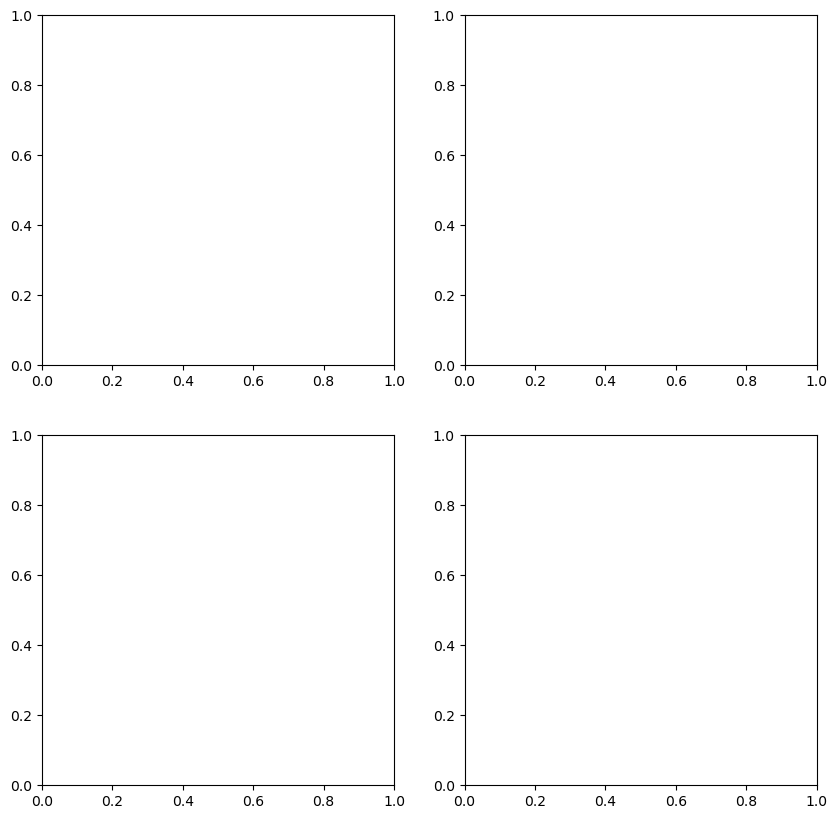

In [197]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

random = np.random.default_rng(seed=42)
ratio = 1.5
fs = np.linspace(0, 1, 100)

threshold = 2
plot_df(tess, ax1, threshold, ratio)

threshold = 4
plot_df(tess, ax2, threshold, ratio)

threshold = 6
plot_df(tess, ax3, threshold, ratio)

threshold = 8
plot_df(tess, ax4, threshold, ratio)

plt.tight_layout()
#plt.savefig(path+'figures/tess_period_ratios_3_2.png')
plt.show()


2:1 period ratios

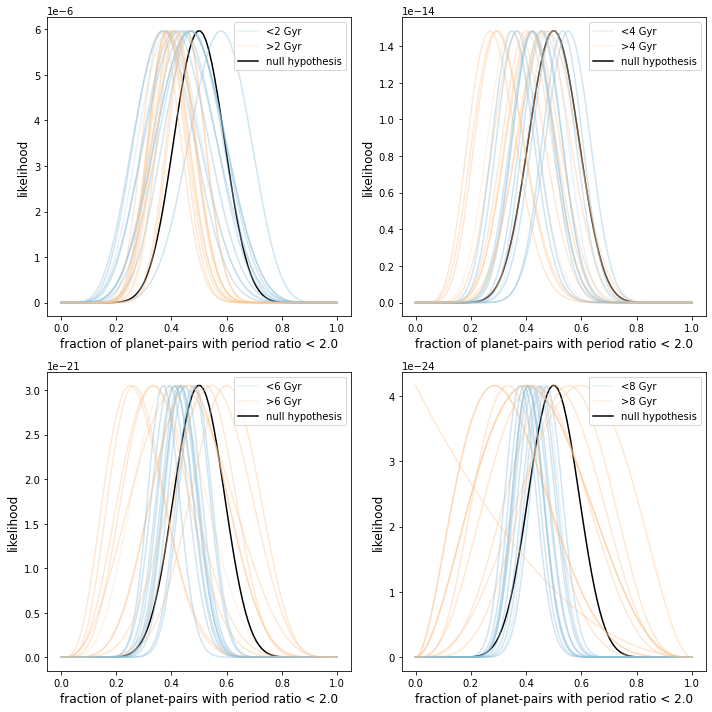

In [85]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

random = np.random.default_rng(seed=42)
ratio = 2.
fs = np.linspace(0, 1, 100)

threshold = 2
plot_df(tess, ax1, threshold, ratio)

threshold = 4
plot_df(tess, ax2, threshold, ratio)

threshold = 6
plot_df(tess, ax3, threshold, ratio)

threshold = 8
plot_df(tess, ax4, threshold, ratio)

plt.tight_layout()
plt.savefig(path+'figures/tess_period_ratios_2_1.png')
plt.show()


### Altogether

In [128]:
print(kepler_planet_enriched[['kepid','age','koi_period','iso_age','iso_age_err']].head())
print(k2[['kepid','age','pl_orbper','st_age','ageerr']].head())
print(tess[['id_starname','age','orbper','iso_age','ageerr']].head())

     kepid        age  koi_period  iso_age  iso_age_err
0  1293379  13.783070   27.556452    13.04        2.775
1  1432789   3.500096    9.931463     6.26        2.010
2  1432789   5.039992    4.578344     6.26        2.010
3  1725016   4.980789    7.407425     4.02        1.540
4  1871056   2.159588   40.806533     2.38        0.485
        kepid       age  pl_orbper  st_age  ageerr
1       K2-33  0.008747   5.424865   0.009   0.001
8   V1298 Tau  0.023411   8.249580   0.023   0.004
9   V1298 Tau  0.020988  12.403200   0.023   0.004
10  V1298 Tau  0.024119  60.000000   0.023   0.004
11  V1298 Tau  0.038258  24.141341   0.028   0.004
   id_starname       age     orbper iso_age  ageerr
0  kic10797460  9.385764   9.488036   3.651  4.1080
1  kic10797460  4.547089  54.418383   3.651  4.1080
2  kic10811496  5.629228  19.899140   4.867  3.8130
3  kic10854555  7.189457   2.525592   4.612  4.7560
4  kic10872983 -0.049067  11.094321   3.182  3.2745


Are there any overlaps between the TESS and Kepler datasets? 

In [135]:
tess['id_starname'] = tess.id_starname.str.replace('^.{0,3}','').astype('int64') # strip "kic"/"tic" from name
tess.merge(kepler_planet_enriched, left_on='id_starname', right_on='kepid')

,id_starname,iso_teff_x,iso_teff_err1_x,iso_teff_err2_x,iso_logg_x,iso_logg_err1_x,iso_logg_err2_x,iso_feh_x,iso_feh_err1_x,iso_feh_err2_x,...,RUWE,num_gaia_companions,Kmag_final_prov,evstate,logR,is_giant,fractional_err1,fractional_err2,iso_age_err,age_y


In [ ]:
kepler_planet_enriched['ageerr'] = kepler_planet_enriched['iso_age_err']
k2['koi_period'] = k2['pl_orbper']
k2['iso_age'] = k2['st_age']
tess['koi_period'] = tess['orbper']
tess['kepid'] = tess['id_starname']

kepler_planet_enriched_subset = kepler_planet_enriched[['kepid','koi_period','iso_age','ageerr']]
k2_subset = k2[['kepid','koi_period','iso_age','ageerr']]
tess_subset = tess[['kepid','koi_period','iso_age','ageerr']]

altogether = pd.concat([kepler_planet_enriched_subset, k2_subset, tess_subset])
altogether['age'] = np.random.normal(altogether['iso_age'], altogether['ageerr'])
altogether['kepid'] = altogether['kepid'].astype(str)


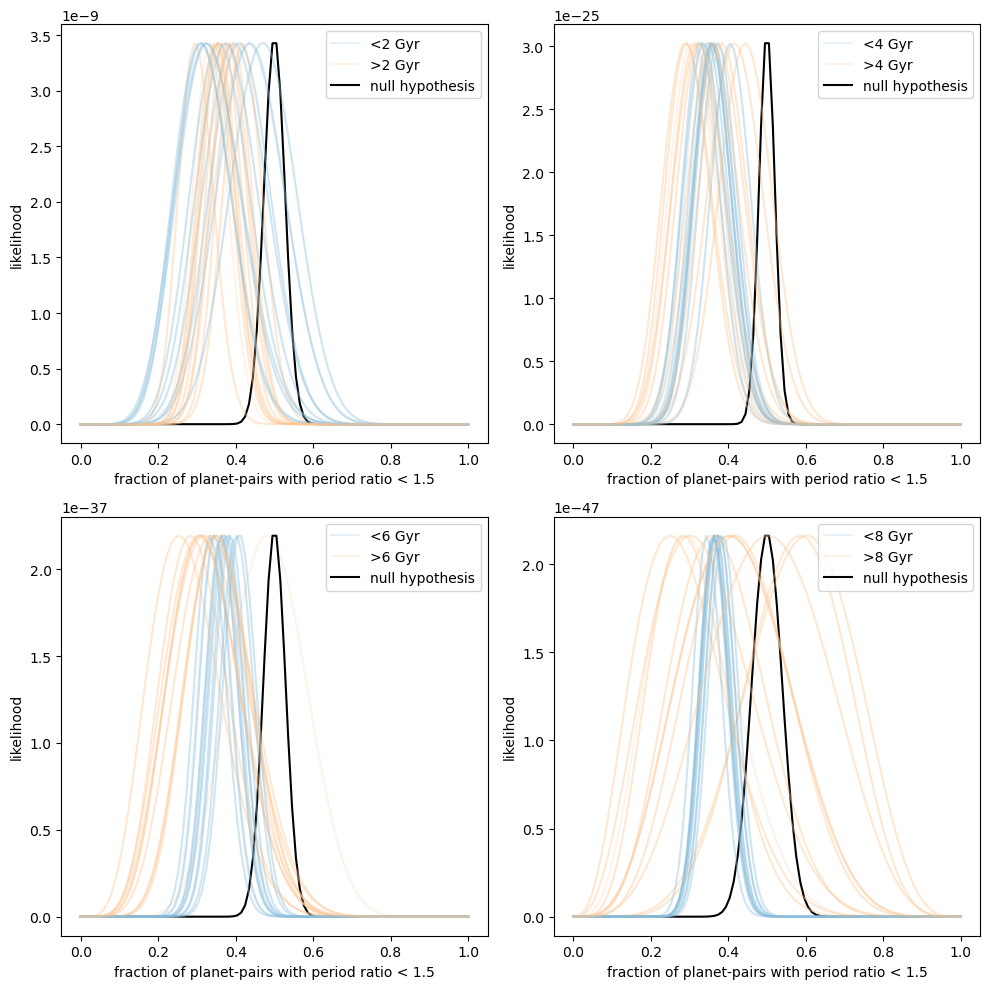

In [211]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

random = np.random.default_rng(seed=42)
ratio = 1.5
fs = np.linspace(0, 1, 100)

threshold = 2
plot_df(altogether, ax1, threshold, ratio)

threshold = 4
plot_df(altogether, ax2, threshold, ratio)

threshold = 6
plot_df(altogether, ax3, threshold, ratio)

threshold = 8
plot_df(altogether, ax4, threshold, ratio)

plt.tight_layout()
plt.savefig(path+'figures/all_period_ratios_3_2_weighted.png')
plt.show()


[  1.66676689  19.66708744  12.78076071 ...  63.84826828 735.40213465
  11.51796524] [  3.18893143   3.43346123   2.16442399   4.39282925   2.76464323
   2.69359133   1.02637813   3.15975854   2.91513327   6.12356919
  17.85102025   1.93015201  55.32001445   1.11906672   4.33692726
   4.89117308   1.69153547   8.27359277   1.66622851   1.78153455
   1.98812242   1.02884817   1.93237689   1.8573425    2.04285656
   2.02085096   1.38491128   1.84526012   5.24173135   2.89026926
   9.50413258   7.48554716   1.26966438   3.47642472   2.81264956
   3.43346123   4.53081999   1.53944509   3.21586274   3.41634021
   6.9749486    1.40889719  15.47882255   4.95064411   2.21920238
  10.98648121  16.84998962 296.06545792   3.74052836   1.00000234
   5.49670715   4.47850885  14.11490105   4.77990371   6.35077916
  21.67416226   2.51661332   3.41283514  15.98245545  54.54548551
  19.60794098   5.57279513   2.17211093   3.15553731   1.00021707
  25.24281095   1.00005613   1.36980777   2.00283037   1.

NameError: name 'dfadf' is not defined

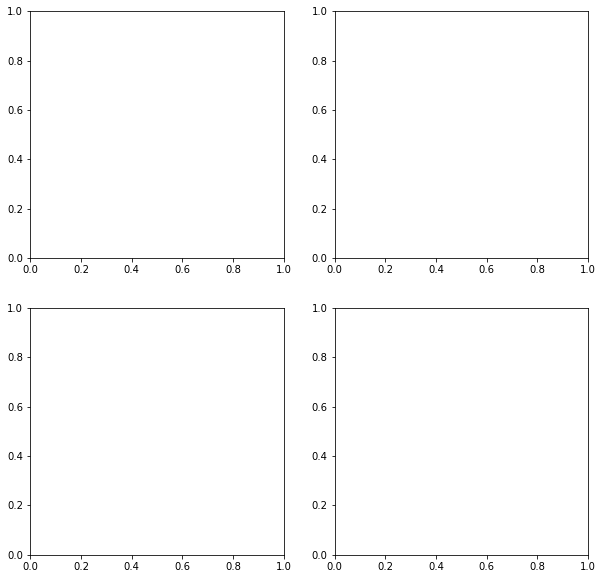

In [190]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

random = np.random.default_rng(seed=42)
ratio = 2.
fs = np.linspace(0, 1, 100)

threshold = 2
plot_df(altogether, ax1, threshold, ratio)

threshold = 4
plot_df(altogether, ax2, threshold, ratio)

threshold = 6
plot_df(altogether, ax3, threshold, ratio)

threshold = 8
plot_df(altogether, ax4, threshold, ratio)

plt.tight_layout()
#plt.savefig(path+'figures/all_period_ratios_2_1.png')
plt.show()


#### Applying a slightly informative prior

We know that planets interior to commensurability are more likely to transit than those exterior to it. How much so? And how to apply this prior? Per Eqn 7 in Winn 2010 (https://arxiv.org/pdf/1001.2010.pdf), the impact parameter is directly related to semi-major axis. There are inclination and eccentricity considerations, but those are going to be small for multi-planet systems, eg. for a multi-planet system, I can assume that i is 2 degrees (Fabrycky+ 2014; Van Eylen+ 2019).

Using the basic version of Kepler's Third Law, the where $P_2$ and $a_2$ are the outer planet's period and semi-major axis, respectively, $a_{1, 1.6}$/$a_{1, 1.4}$ = 1.1. This means a 10% increase in transit likelihood when the 1.6 period ratio outer planet is moved to a 1.4 period ratio.

Applying this prior requires a baseline of the inner planet's period for each multi. Does that mean that I need to have a system-per-row table with inner planet period and all period ratios of that system? EDIT: This is false.

In [13]:
def prior(outer, inner):
    
    """
    Do I apply this per multi for all systems, or just for systems with planets in 1.4 to 1.6 period ratios?
    """
    
    outer_a = outer**(2/3.)
    inner_a = inner**(2/3.)
    
    return outer_a/inner_a

prior(1.6, 1.)

def binomial_pmf_weighted(f, array, ratio): 
    
    """
    Compute bionmial distribution probability mass function (PMF). 
    If I toss a coin and get some observed distribution of planet period ratios < and > than some integer ratio, 
    what's the probability that the true bias of the coin is f? 
    That is, if the coin is fair (if planet pairs are evenly distributed around integer ratios), 
    then I'd expect the peak of the likelihood function to be at f=0.5.
    Weight by a prior that closer-in planets are more likely to transit.
    
    Inputs:
    - f: coin bias test fraction
    - array: array of observed ratios [np.array]
    - ratio: the planet-period ratio in question
    
    Returns:
    - PMF: probability mass function
    
    """
    
    less_than = array[(array >= ratio - 0.1) & (array <= ratio)]
    greater_than = array[(array <= ratio + 0.1) & (array >= ratio)]
    
    # bin less_than and greater_than into 0.025 bins
    less_than_bins = np.linspace(ratio-0.1, ratio, 5)
    greater_than_bins = np.linspace(ratio, ratio+0.1, 5)
    
    less_than_binned, _ = np.histogram(less_than, bins=less_than_bins)
    greater_than_binned, _ = np.histogram(greater_than, bins=greater_than_bins)
    #print(less_than_binned)
    
    # Calculate prior() for each of those bins to get new weights
    less_adjusted = []
    greater_adjusted = []
    for i in range(4):
        # calculate weight: prior takes outer, inner
        less_weight = prior(ratio, less_than_bins[i])
        # multiply weight to raw bin count
        less_adjusted.append(less_than_binned[i] / less_weight)
        
        greater_weight = prior(greater_than_bins[i], ratio)
        greater_adjusted.append(greater_than_binned[i] * greater_weight)    
    
    likelihood = f**(np.sum(less_adjusted)) * (1-f)**(np.sum(greater_adjusted))
                   
    return likelihood


def binomial_null(f, n):
    
    """
    Construct fair-coin-toss binomial distribution.
    
    Inputs:
    - f: 0.5 for a fair coin
    - n: number of flips (should be equal to the sample size being compared)
    """
    
    n = n/2 # half for heads; half for tails
    likelihood = (f**n) * ((1-f)**n)
    
    return likelihood

def binomial_pmf(f, array, ratio): 
    
    """
    Compute bionmial distribution probability mass function (PMF). 
    If I toss a coin and get some observed distribution of planet period ratios < and > than some integer ratio, 
    what's the probability that the true bias of the coin is f? 
    That is, if the coin is fair (if planet pairs are evenly distributed around integer ratios), 
    then I'd expect the peak of the likelihood function to be at f=0.5.
    
    Inputs:
    - f: coin bias test fraction
    - array: array of observed ratios [np.array]
    - ratio: the planet-period ratio in question
    
    Returns:
    - PMF: probability mass function
    
    """
    
    less_than = array[(array >= ratio - 0.1) & (array <= ratio)]
    greater_than = array[(array <= ratio + 0.1) & (array >= ratio)]
    #print(f"<{ratio}:", f"{len(less_than)}")
    #print(f">{ratio}:", f"{len(greater_than)}")
    likelihood = f**(len(less_than)) * (1-f)**(len(greater_than))
                   
    return likelihood


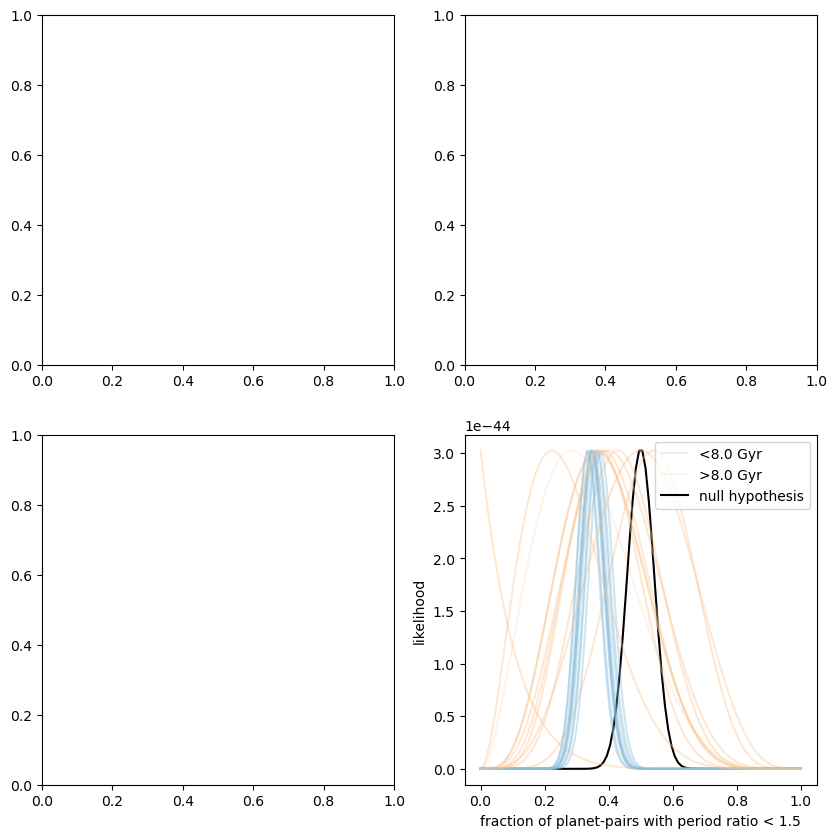

In [241]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
young_peaks, old_peaks = plot_df(altogether, ax4, threshold=8., ratio=1.5)
#plt.show()

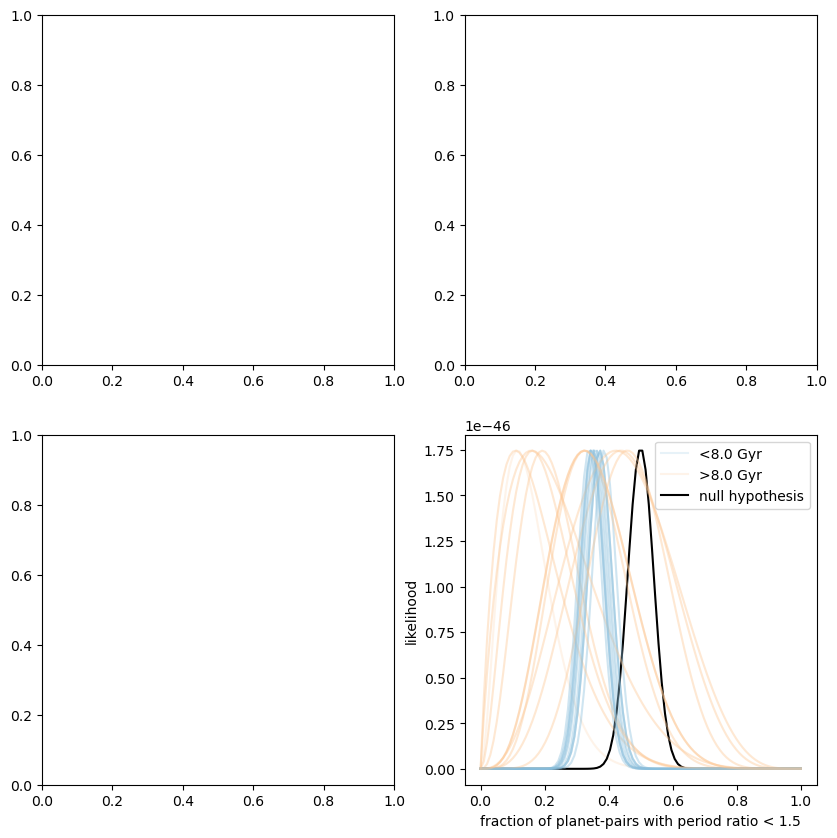

In [242]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
young_peaks_weighted, old_peaks_weighted = plot_df_weighted(altogether, ax4, threshold=8., ratio=1.5)
plt.show()

In [244]:
np.mean(young_peaks), np.mean(old_peaks), np.mean(young_peaks_weighted), np.mean(old_peaks_weighted)

(0.3498622589531681,
 0.35078053259871445,
 0.35996326905417814,
 0.2745638200183655)

In [245]:
np.std(young_peaks), np.std(old_peaks), np.std(young_peaks_weighted), np.std(old_peaks_weighted)

(0.01238818876329847,
 0.13890539406667834,
 0.013804679869947562,
 0.12548470599588324)

#### 2:1 ratio

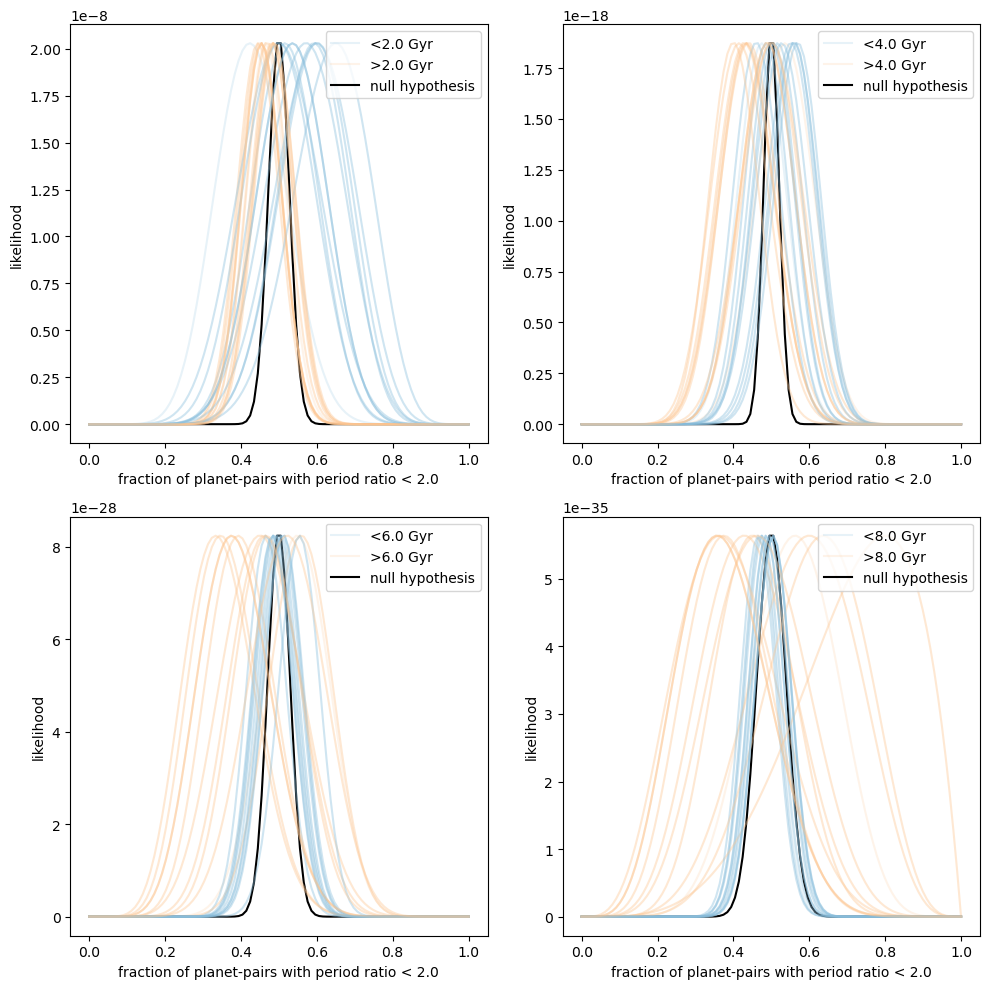

In [246]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
young_peaks2, old_peaks2 = plot_df(altogether, ax1, threshold=2., ratio=2.)

young_peaks4, old_peaks4 = plot_df(altogether, ax2, threshold=4., ratio=2.)

young_peaks6, old_peaks6 = plot_df(altogether, ax3, threshold=6., ratio=2.)

young_peaks8, old_peaks8 = plot_df(altogether, ax4, threshold=8., ratio=2.)

plt.tight_layout()
plt.savefig(path+'figures/weighted_period_ratios_2_1.png')
plt.show()


In [247]:
print(np.mean(young_peaks2), np.mean(old_peaks2))
print(np.std(young_peaks2), np.std(old_peaks2))
print("")
print(np.mean(young_peaks4), np.mean(old_peaks4))
print(np.std(young_peaks4), np.std(old_peaks4))
print("")
print(np.mean(young_peaks6), np.mean(old_peaks6))
print(np.std(young_peaks6), np.std(old_peaks6))
print("")
print(np.mean(young_peaks8), np.mean(old_peaks8))
print(np.std(young_peaks8), np.std(old_peaks8))
print("")

0.5482093663911846 0.4664830119375574
0.05859708405342083 0.01480671762772919

0.5188246097337006 0.4600550964187329
0.03398853172327226 0.04206054174691932

0.4995408631772268 0.43893480257116624
0.022938468313676404 0.07672944245821997

0.487603305785124 0.48943985307621674
0.013681969169652277 0.1369059471958706



### Old stuff, that I'm leaving alone for now in case I need to return to it

In [30]:
old_ratios1 = period_ratios(1)[0]
old_ratios2 = period_ratios(2)[0]
old_ratios3 = period_ratios(3)[0]
old_ratios4 = period_ratios(4)[0]
old_ratios5 = period_ratios(5)[0]
old_ratios6 = period_ratios(6)[0]
old_ratios7 = period_ratios(7)[0]
old_ratios8 = period_ratios(8)[0]

young_ratios1 = period_ratios(1)[1]
young_ratios2 = period_ratios(2)[1]
young_ratios3 = period_ratios(3)[1]
young_ratios4 = period_ratios(4)[1]
young_ratios5 = period_ratios(5)[1]
young_ratios6 = period_ratios(6)[1]
young_ratios7 = period_ratios(7)[1]
young_ratios8 = period_ratios(8)[1]

In [31]:
print(len(old_ratios8))
print(len(old_ratios4))
print(len(young_ratios8))
print(len(young_ratios4))

83
238
305
150


In [32]:
cut = 4
old_ratios1 = old_ratios1[old_ratios1 <= cut]
old_ratios2 = old_ratios2[old_ratios2 <= cut]
old_ratios3 = old_ratios3[old_ratios3 <= cut]
old_ratios4 = old_ratios4[old_ratios4 <= cut]
old_ratios5 = old_ratios5[old_ratios5 <= cut]
old_ratios6 = old_ratios6[old_ratios6 <= cut]
old_ratios7 = old_ratios7[old_ratios7 <= cut]
old_ratios8 = old_ratios8[old_ratios8 <= cut]

young_ratios1 = young_ratios1[young_ratios1 <= cut]
young_ratios2 = young_ratios2[young_ratios2 <= cut]
young_ratios3 = young_ratios3[young_ratios3 <= cut]
young_ratios4 = young_ratios4[young_ratios4 <= cut]
young_ratios5 = young_ratios5[young_ratios5 <= cut]
young_ratios6 = young_ratios6[young_ratios6 <= cut]
young_ratios7 = young_ratios7[young_ratios7 <= cut]
young_ratios8 = young_ratios8[young_ratios8 <= cut]

In [33]:
old_ratios4 = old_ratios4[(old_ratios4 > 1.3) & (old_ratios4 < 2.2)] # 0.2 around area of interest
old_ratios8 = old_ratios8[(old_ratios8 > 1.3) & (old_ratios8 < 2.2)]

young_ratios4 = young_ratios4[(young_ratios4 > 1.3) & (young_ratios4 < 2.2)]
young_ratios8 = young_ratios8[(young_ratios8 > 1.3) & (young_ratios8 < 2.2)]


In [34]:
kstest(old_ratios8, young_ratios8)

KstestResult(statistic=0.19743589743589743, pvalue=0.19080563664410377)

In [35]:
kstest(old_ratios4, old_ratios8)

KstestResult(statistic=0.12962962962962962, pvalue=0.7334816610499324)

In [36]:
kstest(young_ratios4, young_ratios8)

KstestResult(statistic=0.05623342175066313, pvalue=0.9984465952623691)

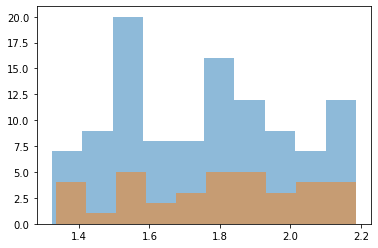

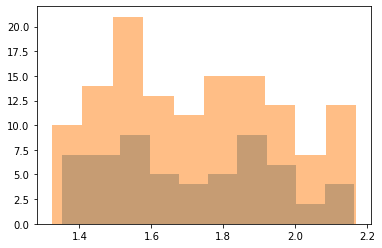

In [37]:
plt.hist(old_ratios4, alpha=0.5)
plt.hist(old_ratios8, alpha=0.5)
plt.show()

plt.hist(young_ratios4, alpha=0.5)
plt.hist(young_ratios8, alpha=0.5)
plt.show()

#### Let's ask this question in a Bayesian way: if I flip a fair coin around the 3:2 and 2:1 period ratios, to what confidence can I claim that the observed period ratios come from a biased coin, and how biased? 

In [38]:
#all_ratios_3_2 = all_ratios[(all_ratios > 1.4) & (all_ratios < 1.6)]
#all_ratios_2_1 = all_ratios[(all_ratios > 1.9) & (all_ratios < 2.1)]
#print(all_ratios_3_2)
#print(all_ratios_2_1)

### 4 Gyrs
# 3:2
young4_3_2 = young_ratios4[(young_ratios4 > 1.4) & (young_ratios4 < 1.6)]
old4_3_2 = old_ratios4[(old_ratios4 > 1.4) & (old_ratios4 < 1.6)]

# 2:1
young4_2_1 = young_ratios6[(young_ratios6 > 1.9) & (young_ratios6 < 2.1)]
old4_2_1 = old_ratios6[(old_ratios6 > 1.9) & (old_ratios6 < 2.1)]

### 6 Gyrs
# 3:2
young6_3_2 = young_ratios6[(young_ratios6 > 1.4) & (young_ratios6 < 1.6)]
old6_3_2 = old_ratios6[(old_ratios6 > 1.4) & (old_ratios6 < 1.6)]

# 2:1
young6_2_1 = young_ratios6[(young_ratios6 > 1.9) & (young_ratios6 < 2.1)]
old6_2_1 = old_ratios6[(old_ratios6 > 1.9) & (old_ratios6 < 2.1)]

### 8 Gyrs
# 3:2
young8_3_2 = young_ratios8[(young_ratios8 > 1.4) & (young_ratios8 < 1.6)]
old8_3_2 = old_ratios8[(old_ratios8 > 1.4) & (old_ratios8 < 1.6)]

# 2:1
young8_2_1 = young_ratios8[(young_ratios8 > 1.9) & (young_ratios8 < 2.1)]
old8_2_1 = old_ratios8[(old_ratios8 > 1.9) & (old_ratios8 < 2.1)]

In [ ]:
binomial_pmf(fs, young4_3_2, 1.5) 

In [194]:
np.linspace(1.5-0.1, 1.5, 5)

array([1.4  , 1.425, 1.45 , 1.475, 1.5  ])

In [195]:
def binomial_pmf(f, array, ratio): 
    
    """
    Compute bionmial distribution probability mass function (PMF). 
    If I toss a coin and get some observed distribution of planet period ratios < and > than some integer ratio, 
    what's the probability that the true bias of the coin is f? 
    That is, if the coin is fair (if planet pairs are evenly distributed around integer ratios), 
    then I'd expect the peak of the likelihood function to be at f=0.5.
    
    Inputs:
    - f: coin bias test fraction
    - array: array of observed ratios [np.array]
    - ratio: the planet-period ratio in question
    
    Returns:
    - PMF: probability mass function
    
    """
    
    less_than = array[(array >= ratio - 0.1) & (array <= ratio)]
    greater_than = array[(array <= ratio + 0.1) & (array >= ratio)]
    
    # bin less_than and greater_than into 0.025 bins
    less_than_bins = np.linspace(ratio-0.1, ratio, 5)
    greater_than_bins = np.linspace(ratio, ratio+0.1, 5)
    
    less_than_binned, _ = np.histogram(less_than, bins=less_than_bins)
    greater_than_binned, _ = np.histogram(greater_than, bins=greater_than_bins)
    
    # Calculate prior() for each of those bins to get new weights
    less_adjusted = []
    greater_adjusted = []
    for i in less_than_binned:
        # calculate weight: prior takes outer, inner
        less_weight = prior(ratio, less_than_bins[i])
        # multiply weight to raw bin count
        less_adjusted.append(len(less_than_binned[i]) * less_weight)
        
        greater_weight = prior(greater_than_bins[i], ratio)
        greater_adjusted.append(len(greater_than_binned[i]) * greater_weight)    
    
    likelihood = f**(np.sum(less_adjusted)) * (1-f)**(np.sum(greater_adjusted))
                   
    return likelihood

def binomial_null(f):
    
    """
    Construct fair-coin-toss binomial distribution.
    Let's say we toss the fair coin 30 times.
    """
    
    likelihood = (f**15) * ((1-f)**15)
    
    return likelihood

import matplotlib
plt.rcParams.update(matplotlib.rcParamsDefault)

### calculate binomial PMFs
ratio = 1.5
threshold = 8
fs = np.linspace(0, 1, 100)
#fair_likelihoods = binomial_pmf(fs, young_ratios, ratio) # all_ratios
binomial_young4_3_2 = binomial_pmf(fs, young4_3_2, 1.5) 
binomial_old4_3_2 = binomial_pmf(fs, old4_3_2, 1.5) 
binomial_young4_2_1 = binomial_pmf(fs, young4_2_1, 2) 
binomial_old4_2_1 = binomial_pmf(fs, old4_2_1, 2) 

binomial_young6_3_2 = binomial_pmf(fs, young6_3_2, 1.5) 
binomial_old6_3_2 = binomial_pmf(fs, old6_3_2, 1.5) 
binomial_young6_2_1 = binomial_pmf(fs, young6_2_1, 2) 
binomial_old6_2_1 = binomial_pmf(fs, old6_2_1, 2) 

binomial_young8_3_2 = binomial_pmf(fs, young8_3_2, 1.5) 
binomial_old8_3_2 = binomial_pmf(fs, old8_3_2, 1.5) 
binomial_young8_2_1 = binomial_pmf(fs, young8_2_1, 2) 
binomial_old8_2_1 = binomial_pmf(fs, old8_2_1, 2) 

### normalize
#fair_likelihoods_old4_normalized = fair_likelihoods_old4*(max(fair_likelihoods_young4)/max(fair_likelihoods_old4))
normalized_binomial_null = binomial_null(fs)*(max(binomial_young8_3_2)/max(binomial_null(fs)))
binomial_old4_3_2_normalized = binomial_old4_3_2*(max(binomial_young4_3_2)/max(binomial_old4_3_2))
binomial_old4_2_1_normalized = binomial_old4_2_1*(max(binomial_young4_2_1)/max(binomial_old4_2_1))
binomial_old6_3_2_normalized = binomial_old6_3_2*(max(binomial_young6_3_2)/max(binomial_old6_3_2))
binomial_old6_2_1_normalized = binomial_old6_2_1*(max(binomial_young6_2_1)/max(binomial_old6_2_1))
binomial_old8_3_2_normalized = binomial_old8_3_2*(max(binomial_young8_3_2)/max(binomial_old8_3_2))
binomial_old8_2_1_normalized = binomial_old8_2_1*(max(binomial_young8_2_1)/max(binomial_old8_2_1))

### plot to compare young vs old
plt.plot(fs, binomial_young8_3_2, label=f'observed <{threshold} Gyrs')
plt.plot(fs, binomial_old8_3_2_normalized, label=f'observed >{threshold} Gyrs')
plt.plot(fs, normalized_binomial_null, label=r'null hypothesis')
plt.fill_between(fs[np.argmax(binomial_young8_3_2):51], binomial_young8_3_2[np.argmax(binomial_young8_3_2):51], zorder=2)
plt.fill_between(fs[np.argmax(binomial_old8_3_2_normalized):51], binomial_old8_3_2_normalized[np.argmax(binomial_old8_3_2_normalized):51], zorder=1)

plt.xlabel(f'fraction of planet-pairs with period ratio < {ratio}')
plt.ylabel('likelihood')
#plt.legend(bbox_to_anchor=(1.05, 1))
plt.legend()
plt.savefig(path+'period-ratios/figures/period_ratio_young_old_3_2_8gyrs.pdf', format='pdf', facecolor='white',
           bbox_inches='tight')
plt.show()

"""
### plot to compare different "older than"s
plt.plot(fs, fair_likelihoods_old4, label=f'observed >4 Gyrs')
plt.plot(fs, fair_likelihoods_old6_normalized, label=f'observed >6 Gyrs')
#plt.plot(fs, normalized_binomial_null, label=r'null hypothesis')
plt.fill_between(fs[np.argmax(fair_likelihoods_old4):51], fair_likelihoods_old4[np.argmax(fair_likelihoods_old4):51])
plt.fill_between(fs[50:np.argmax(fair_likelihoods_old6_normalized)+1], fair_likelihoods_old6_normalized[50:np.argmax(fair_likelihoods_old6_normalized)+1])

plt.xlabel(f'fraction of planet-pairs with period ratio < {ratio}')
plt.ylabel('likelihood')
plt.legend()
#plt.savefig('paper/period_ratio_old_4_6gyrs.pdf', format='pdf')
#plt.savefig('paper/period_ratio_3_2_bayes.pdf', format='pdf')
plt.show()
"""


NameError: name 'young4_3_2' is not defined

In [659]:
print("total area under PMF: ", np.trapz(normalized_binomial_null))
print("1 sigma: ", 0.34*np.trapz(normalized_binomial_null))
#area_deviation = np.trapz(binomial_young4_2_1[np.argmax(binomial_young4_2_1):51])
area_deviation = np.trapz(binomial_young4_2_1[50:np.argmax(binomial_young4_2_1)+1])
print("area from peak of PMF to f = 0.5: ", area_deviation)
print("area from peak of PMF to f = 0.5 in sigmas: ", area_deviation/(0.34*np.trapz(normalized_binomial_null)))


total area under PMF:  0.0005599398109936407
1 sigma:  0.00019037953573783784
area from peak of PMF to f = 0.5:  0.0002622822330596965
area from peak of PMF to f = 0.5 in sigmas:  1.3776808102992344


In [635]:
from scipy import signal
null_width = scipy.signal.peak_widths(normalized_binomial_null, [np.argmax(normalized_binomial_null)])
print(null_width)
print(null_width[0][0]/100)
print("distance between peaks: ", 
      (np.argmax(normalized_binomial_null)-np.argmax(binomial_young8_3_2))/(null_width[0][0]))


(array([21.061802]), array([5.4454938e-05]), array([38.969099]), array([60.030901]))
0.21061801996516039
distance between peaks:  0.5697518190506679


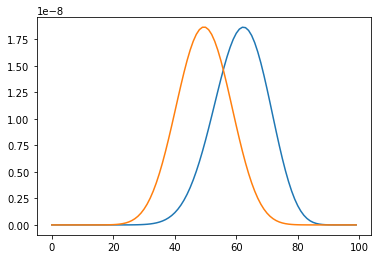

In [439]:
plt.plot(fair_likelihoods)
plt.plot(normalized_binomial_null)
plt.show()

#### Wait, why were there 900 planets before joining with NASA Exoplanets Archive? 

In [ ]:
ds1 = set(kepler_stellar_enriched.kepid)
ds2 = set(crossmatch.loc[crossmatch['planet?'] != 'none'].kepid)
print(len(ds1))
print(len(ds2))
print(ds2.difference(ds1))

Plugged a few of these into MAST and they were all false positives. Then did the same for the kepler_stellar_enriched kepids and they were all planets. Looks like the Bedell cross-match was just out of date?

#### Tests on thresholding vs flag with Sarah B on 17 Aug 2022 

In [254]:
no_score = kois.loc[kois.koi_score.isna()]
#pd.merge(kepler_stellar, positives_kepler, how='inner', left_on='kepid', right_on='kepid')

In [256]:
kepler_planet_enriched_no_score = pd.merge(kepler_stellar, no_score, how='inner', left_on='kepid', right_on='kepid')
print(len(kepler_planet_enriched_no_score.kepid.unique()))

595


In [251]:
len(kepler_planet_enriched.loc[kepler_planet_enriched.koi_score.isna()].kepid.unique())

193

In [244]:
len(positives_kepler_cfp.loc[positives_kepler_cfp.koi_disposition=='FALSE POSITIVE'].kepid.unique())

7

(array([138., 189., 186., 131., 110.,  80.,  37.,  16.,   8.,   8.]),
 array([ 0.81 ,  2.437,  4.064,  5.691,  7.318,  8.945, 10.572, 12.199,
        13.826, 15.453, 17.08 ]),
 <BarContainer object of 10 artists>)

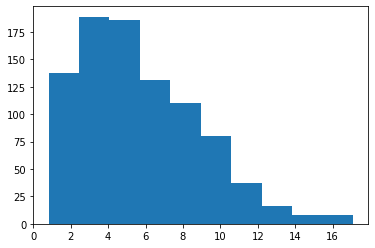

In [258]:
plt.hist(kepler_planet_enriched_cfp.iso_age) # age distribution of the 811 systems that match Berger and have koi_score>0.5

In [ ]:
kepler_planet_enriched_cfp = pd.merge(kepler_stellar, positives_kepler_cfp, how='inner', left_on='kepid', right_on='kepid')
print(len(kepler_planet_enriched_cfp))
print(len(kepler_planet_enriched_cfp.kepid.unique()))

print(kepler_planet_enriched_cfp.groupby('kepid').count().koi_count.reset_index().groupby('koi_count').count())

In [238]:
len(kois.loc[kois.koi_score.isna()].kepid.unique())
sad = kois.loc[kois.koi_score.isna()]
print(len(sad.loc[sad.koi_disposition!='FALSE POSITIVE'].kepid.unique()))
#len(kois.loc[kois.koi_score.isna()].kepid.unique())

595


### Age threshold effect on young-old multiplicities

Which threshold yields the greatest difference between the observed young and old transit multiplicities?

In [24]:
k = kepler_planet_enriched.groupby(['kepid']).count()['koi_count'].reset_index().groupby('koi_count').count().reset_index().kepid + np.array([4, 4, 4, 4, 4])
k = list(k)
k += [0.] * (7 - len(k)) # pad
k = np.array(k)

In [26]:
kepler_planet_enriched.iso_age_err = 0.5 * (np.abs(kepler_planet_enriched.iso_age_err1) + np.abs(kepler_planet_enriched.iso_age_err2))


/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_23568/2077406791.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  kepler_planet_enriched.iso_age_err = 0.5 * (np.abs(kepler_planet_enriched.iso_age_err1) + np.abs(kepler_planet_enriched.iso_age_err2))


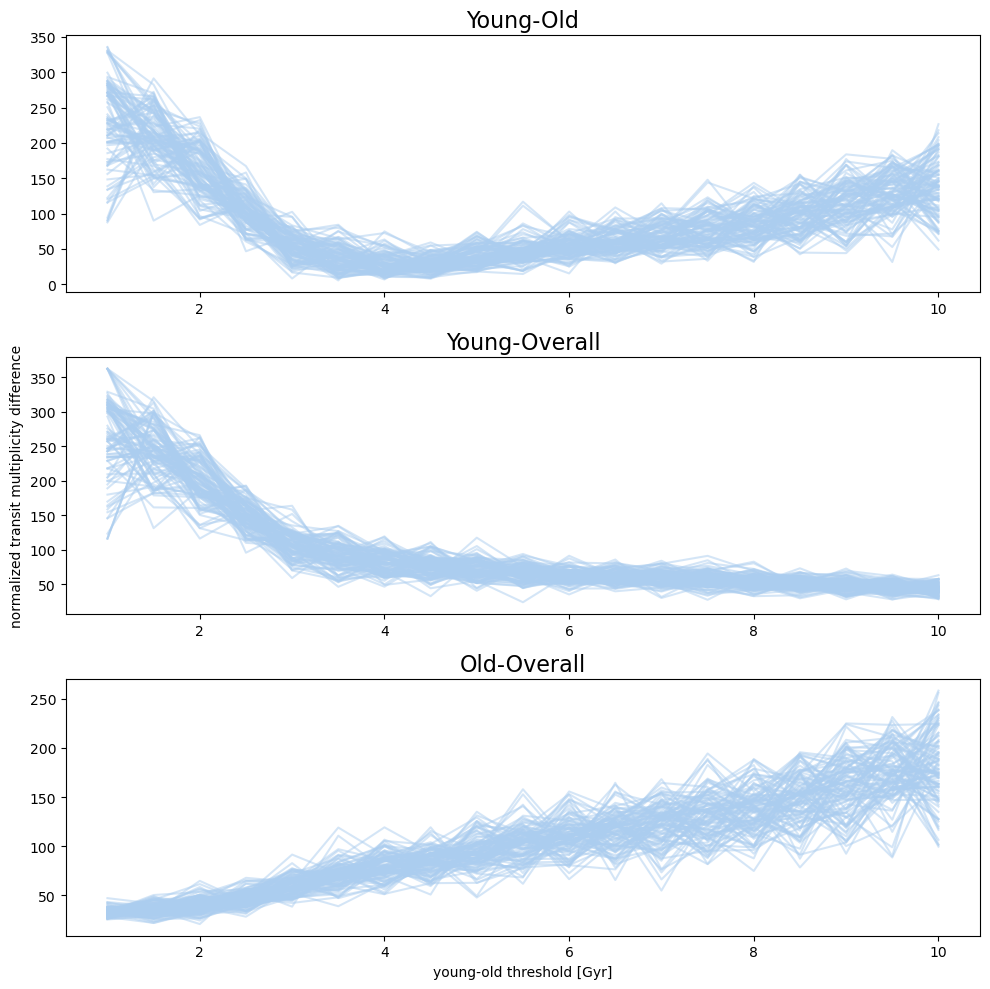

In [772]:
bootstrap = 100
thresholds = np.linspace(1, 10, 19)

fig, axes = plt.subplots(figsize=(10,10))

for b in range(bootstrap):
    young_multiplicities = []
    old_multiplicities = []
    young_differences = []
    old_differences = []
    residuals = []

    ### for each threshold, compute young-old multiplicities and their difference
    for threshold in thresholds:
        #for i in bootstrap:
        kepler_planet_enriched.iso_age_sample = np.random.normal(kepler_planet_enriched.iso_age, kepler_planet_enriched.iso_age_err)

        # young
        young = kepler_planet_enriched.loc[kepler_planet_enriched.iso_age_sample <= threshold] # iso_age_sample
        young_multiplicity = list(young.groupby(['kepid']).count()['koi_count'].reset_index().groupby('koi_count').count().reset_index().kepid)
        young_multiplicity += [0.] * (7 - len(young_multiplicity)) # pad
        young_multiplicity = np.array(young_multiplicity) * np.sum(k) / np.sum(young_multiplicity) # normalize
        young_multiplicities.append(young_multiplicity)

        young_difference = np.abs(young_multiplicity - k) # how much does multiplicity differ from overall sample?
        young_differences.append(young_difference)

        # old
        old = kepler_planet_enriched.loc[kepler_planet_enriched.iso_age_sample > threshold]
        old_multiplicity = list(old.groupby(['kepid']).count()['koi_count'].reset_index().groupby('koi_count').count().reset_index().kepid)
        old_multiplicity += [0.] * (7 - len(old_multiplicity))
        old_multiplicity = np.array(old_multiplicity) * np.sum(k) / np.sum(old_multiplicity)
        old_multiplicities.append(old_multiplicity)

        old_difference = np.abs(old_multiplicity - k)
        old_differences.append(old_difference)

        # residuals
        residual = np.array(young_multiplicity) - np.array(old_multiplicity)
        residual = np.abs(residual)
        residuals.append(residual)


    ### which threshold has greatest young-old difference in observed transit multiplicity?
    residuals = [np.sum(i) for i in residuals]
    #print(np.argmax(residuals))
    #print("Old vs Young: ", residuals)

    ### which threshold has greatest young-overall or old-overall difference in transit multiplicity?
    old_differences = [np.sum(i) for i in old_differences]
    young_differences = [np.sum(i) for i in young_differences]
    #print(np.argmax(old_differences))
    #print("Old vs Overall: ", old_differences)

    #print(np.argmax(young_differences))
    #print("Young vs Overall: ", young_differences)
    
    ax1 = plt.subplot(311)
    ax1.plot(thresholds, residuals, color='#abcdef', alpha=0.5)

    ax2 = plt.subplot(312)
    ax2.plot(thresholds, young_differences, color='#abcdef', alpha=0.5)
    
    ax3 = plt.subplot(313)
    ax3.plot(thresholds, old_differences, color='#abcdef', alpha=0.5)
    
ax1.set_title('Young-Old', size=16)
ax2.set_title('Young-Overall', size=16)
ax2.set_ylabel('normalized transit multiplicity difference')
ax3.set_title('Old-Overall', size=16)
ax3.set_xlabel('young-old threshold [Gyr]')

plt.tight_layout()
plt.savefig('paper/young-old-overall-differences.png', format='png')
plt.show()

/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_23568/1434665903.py:60: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(311)


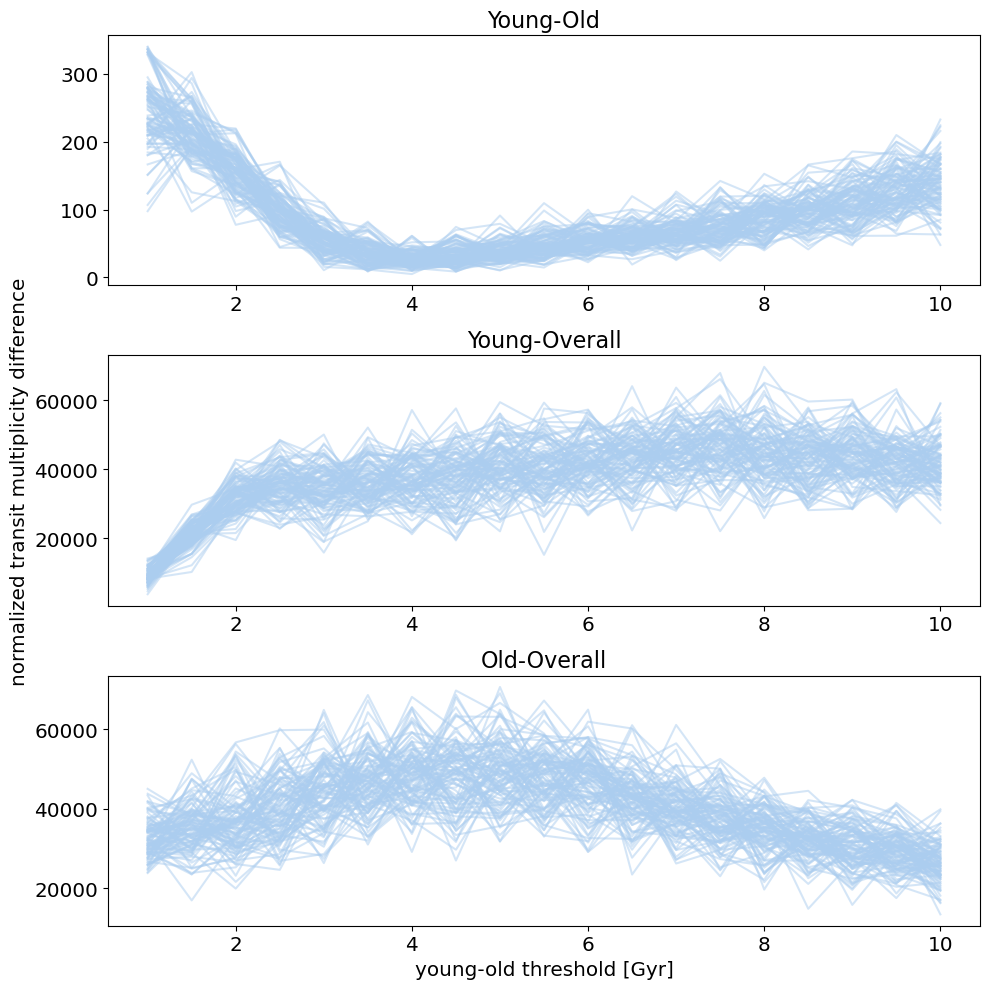

In [28]:
bootstrap = 100
thresholds = np.linspace(1, 10, 19)

fig, axes = plt.subplots(figsize=(10,10))

for b in range(bootstrap):
    young_multiplicities = []
    old_multiplicities = []
    young_differences = []
    old_differences = []
    residuals = []

    ### for each threshold, compute young-old multiplicities and their difference
    for threshold in thresholds:
        #for i in bootstrap:
        kepler_planet_enriched.iso_age_sample = np.random.normal(kepler_planet_enriched.iso_age, kepler_planet_enriched.iso_age_err)

        # young
        young = kepler_planet_enriched.loc[kepler_planet_enriched.iso_age_sample <= threshold] # iso_age_sample
        young_multiplicity = list(young.groupby(['kepid']).count()['koi_count'].reset_index().groupby('koi_count').count().reset_index().kepid)
        young_multiplicity += [0.] * (7 - len(young_multiplicity)) # pad
        young_multiplicity = np.array(young_multiplicity) * np.sum(k) / np.sum(young_multiplicity) # normalize
        young_multiplicities.append(young_multiplicity)

        young_difference = np.abs(young_multiplicity - k) # how much does multiplicity differ from overall sample?
        young_difference = young_difference * len(young) # normalize by size of bin 
        young_differences.append(young_difference)

        # old
        old = kepler_planet_enriched.loc[kepler_planet_enriched.iso_age_sample > threshold]
        old_multiplicity = list(old.groupby(['kepid']).count()['koi_count'].reset_index().groupby('koi_count').count().reset_index().kepid)
        old_multiplicity += [0.] * (7 - len(old_multiplicity))
        old_multiplicity = np.array(old_multiplicity) * np.sum(k) / np.sum(old_multiplicity)
        old_multiplicities.append(old_multiplicity)

        old_difference = np.abs(old_multiplicity - k)
        old_difference = old_difference * len(old) # normalize by size of bin
        old_differences.append(old_difference)

        # residuals
        residual = np.array(young_multiplicity) - np.array(old_multiplicity)
        residual = np.abs(residual)
        residuals.append(residual)


    ### which threshold has greatest young-old difference in observed transit multiplicity?
    residuals = [np.sum(i) for i in residuals]
    #print(np.argmax(residuals))
    #print("Old vs Young: ", residuals)

    ### which threshold has greatest young-overall or old-overall difference in transit multiplicity?
    old_differences = [np.sum(i) for i in old_differences]
    young_differences = [np.sum(i) for i in young_differences]
    #print(np.argmax(old_differences))
    #print("Old vs Overall: ", old_differences)

    #print(np.argmax(young_differences))
    #print("Young vs Overall: ", young_differences)
    
    ax1 = plt.subplot(311)
    ax1.plot(thresholds, residuals, color='#abcdef', alpha=0.5)

    ax2 = plt.subplot(312)
    ax2.plot(thresholds, young_differences, color='#abcdef', alpha=0.5)
    
    ax3 = plt.subplot(313)
    ax3.plot(thresholds, old_differences, color='#abcdef', alpha=0.5)
    
ax1.set_title('Young-Old', size=16)
ax2.set_title('Young-Overall', size=16)
ax2.set_ylabel('normalized transit multiplicity difference')
ax3.set_title('Old-Overall', size=16)
ax3.set_xlabel('young-old threshold [Gyr]')

plt.tight_layout()
#plt.savefig('paper/young-old-overall-differences.png', format='png')
plt.show()

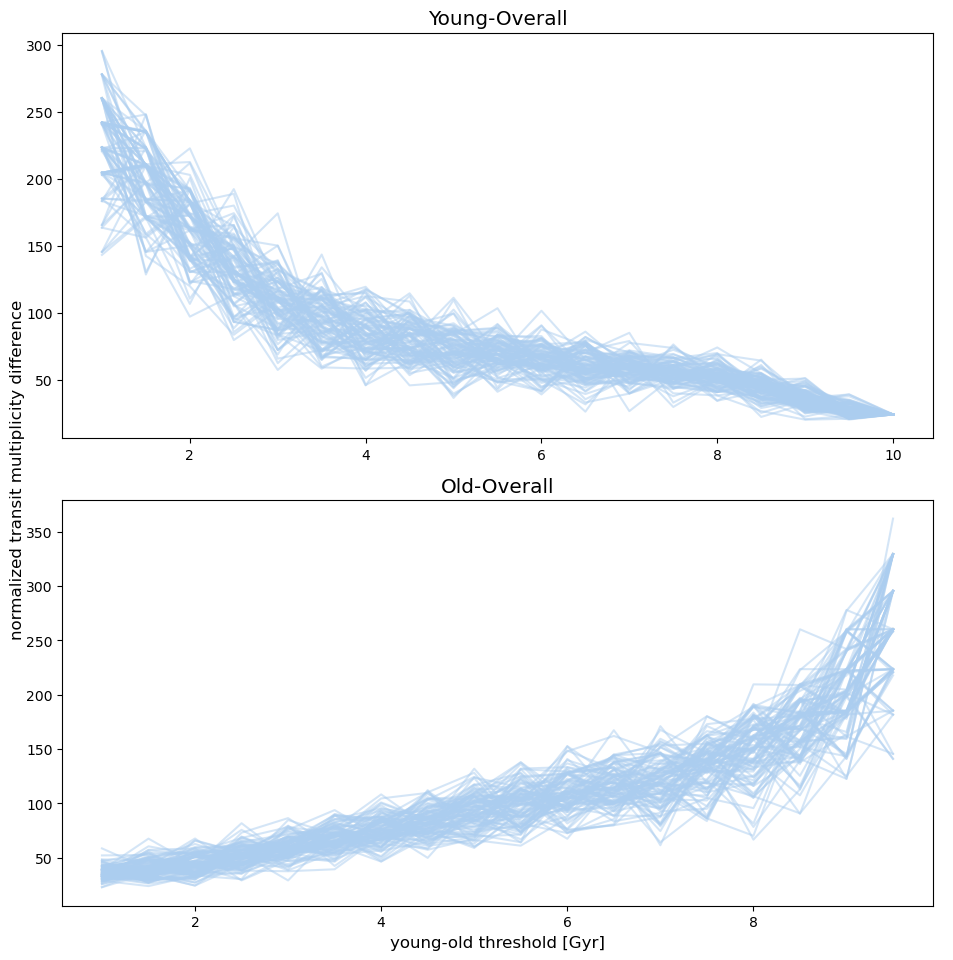

In [71]:
import warnings
warnings.filterwarnings("ignore")

bootstrap = 100
thresholds = np.linspace(1, 10, 19)
thresholds_quantiled = np.linspace(0.1, 1, 19)

fig, axes = plt.subplots(figsize=(10,10), sharex = True, sharey=True)

for b in range(bootstrap):
    young_multiplicities = []
    old_multiplicities = []
    young_differences = []
    old_differences = []
    residuals = []

    ### for each threshold, compute young-old multiplicities and their difference
    for threshold in thresholds_quantiled:
        #for i in bootstrap:
        kepler_planet_enriched.iso_age_sample = np.random.normal(kepler_planet_enriched.iso_age, kepler_planet_enriched.iso_age_err)

        # young
        young = kepler_planet_enriched.loc[kepler_planet_enriched.iso_age_sample <= pd.DataFrame(kepler_planet_enriched.iso_age_sample).quantile(threshold)[0]] # iso_age_sample compared to quantiled age thresholds for uniformly sized bins
        young_multiplicity = list(young.groupby(['kepid']).count()['koi_count'].reset_index().groupby('koi_count').count().reset_index().kepid)
        young_multiplicity += [0.] * (7 - len(young_multiplicity)) # pad
        young_multiplicity = np.array(young_multiplicity) * np.sum(k) / np.sum(young_multiplicity) # normalize
        young_multiplicities.append(young_multiplicity)

        young_difference = np.abs(young_multiplicity - k) # how much does multiplicity differ from overall sample?
        young_differences.append(young_difference)

        # old
        old = kepler_planet_enriched.loc[kepler_planet_enriched.iso_age_sample > pd.DataFrame(kepler_planet_enriched.iso_age_sample).quantile(threshold)[0]] # kepler_planet_enriched.iso_age_sample.quantile(threshold)
        old_multiplicity = list(old.groupby(['kepid']).count()['koi_count'].reset_index().groupby('koi_count').count().reset_index().kepid)
        old_multiplicity += [0.] * (7 - len(old_multiplicity))
        old_multiplicity = np.array(old_multiplicity) * np.sum(k) / np.sum(old_multiplicity)
        old_multiplicities.append(old_multiplicity)

        old_difference = np.abs(old_multiplicity - k)
        old_differences.append(old_difference)

        # residuals
        residual = np.array(young_multiplicity) - np.array(old_multiplicity)
        residual = np.abs(residual)
        residuals.append(residual)


    ### which threshold has greatest young-old difference in observed transit multiplicity?
    residuals = [np.sum(i) for i in residuals]
    #print(np.argmax(residuals))
    #print("Old vs Young: ", residuals)

    ### which threshold has greatest young-overall or old-overall difference in transit multiplicity?
    old_differences = [np.sum(i) for i in old_differences]
    young_differences = [np.sum(i) for i in young_differences]
    #print(np.argmax(old_differences))
    #print("Old vs Overall: ", old_differences)

    #print(np.argmax(young_differences))
    #print("Young vs Overall: ", young_differences)
    
    ax2 = plt.subplot(211)
    ax2.plot(thresholds, young_differences, color='#abcdef', alpha=0.5)
    
    ax3 = plt.subplot(212)
    ax3.plot(thresholds, old_differences, color='#abcdef', alpha=0.5)
    
ax2.set_title('Young-Overall')
ax3.set_title('Old-Overall')
#ax3.set_xlabel('young-old threshold [Gyr]')

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.ylabel('normalized transit multiplicity difference')
plt.xlabel('young-old threshold [Gyr]')
plt.tight_layout()
plt.savefig('paper/young-old-differences.png', format='png')
plt.show()

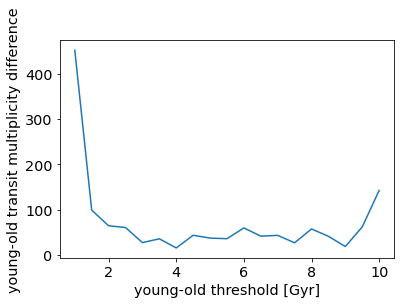

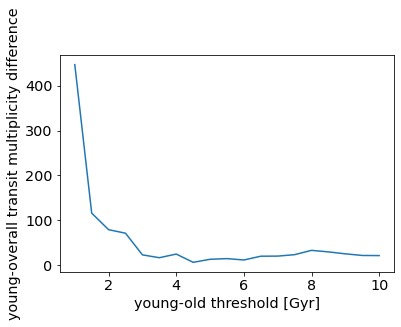

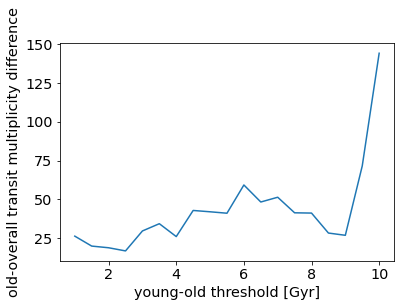

In [730]:
plt.plot(thresholds, residuals)
plt.ylabel('young-old transit multiplicity difference')
plt.xlabel('young-old threshold [Gyr]')
plt.show()

plt.plot(thresholds, young_differences)
plt.ylabel('young-overall transit multiplicity difference')
plt.xlabel('young-old threshold [Gyr]')
plt.show()

plt.plot(thresholds, old_differences)
plt.ylabel('old-overall transit multiplicity difference')
plt.xlabel('young-old threshold [Gyr]')
plt.show()

Outside of the most extremes of 1 and 10 Gyrs, there doesn't seem to be any specific threshold that creates a noticeably big mismatch in young-old transit multiplicities.